Это черновик распознавания циферок. Тут довольно страшный код :(  

На то он и исследовательскний :)

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout

from PIL import ImageEnhance
import json
import scipy.misc

import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from PIL import Image
import skimage
import cv2

from PIL import Image, ImageOps
from scipy import ndimage, misc
import os
import random
import string
from keras.models import model_from_json
import pandas as pd
import keras2onnx
import onnxruntime

Перевод модели в формат ONNX

https://github.com/onnx/keras-onnx

In [65]:
model = model_from_json(open("mnist_mega_model_2.json").read())
model.load_weights('best_great_model_sep_1_7.hdf5')

In [66]:
onnx_model = keras2onnx.convert_keras(model, model.name)
temp_model_file = 'mnist_mega_model_2.onnx'
keras2onnx.save_model(onnx_model, temp_model_file)
sess = onnxruntime.InferenceSession(temp_model_file)

tf executing eager_mode: True
INFO:keras2onnx:tf executing eager_mode: True
The ONNX operator number change on the optimization: 65 -> 31
INFO:keras2onnx:The ONNX operator number change on the optimization: 65 -> 31


In [67]:
sample_digit = Image.open("our_sample_digits/0_0FJSN.png").resize((28, 28), Image.ANTIALIAS)
sample_digit

In [68]:
digit_array = np.array(sample_digit)

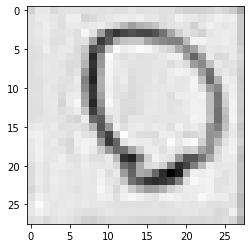

In [69]:
plt.imshow(digit_array, "gray")

Предсказание цифры

In [70]:
model.predict(digit_array.reshape(1, 28, 28, 1)).argmax()

0

То же самое, только с помощью ONNX

In [71]:
data = digit_array.reshape(1, 1, 28, 28, 1).astype(np.float32)
input_names = sess.get_inputs()
feed = zip(sorted(i_.name for i_ in input_names), data)

actual = sess.run(None, dict(feed))


In [72]:
actual[0][0].argmax()

0

Этот код – применение к вырезке верхней части

In [73]:
def rand_line():
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))

In [74]:
top_margin =312
bottom_margin = -18
left_margin = 124
right_margin = 330
cell_width = 36

In [75]:
filename = "tasks_sample/0d521b8e-2bc1-4dd7-b28e-6ee5cb6cca30__1_fio.jpg"

In [76]:
def extract_digits(filename):
    im = Image.open(filename)
    im = np.mean(im, axis=2)
    #plt.figure(figsize=(20, 20))
    img = im[top_margin: bottom_margin, left_margin:right_margin]
    #plt.imshow(img, "gray")
    
    digits = []

    for i in range(5):
        next_digit = img[:, (cell_width + 8) * i :(cell_width + 8) * i + (cell_width-3) ]
        digits.append(next_digit)
        
    return digits

In [77]:
all_digits = []

for filename in os.listdir("tasks_sample"):
    if "fio" in filename:
        next_digits = extract_digits("tasks_sample/{}".format(filename))
        all_digits += next_digits

In [78]:
def recognize_digit(image_array):
    im = Image.fromarray(image_array.astype(np.uint8))
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im)
    if len(im.shape) == 3:
        im = np.mean(im, axis=2)

    prediction = model.predict(im.reshape(1, 28, 28,1))
    predicted_value = np.argmax(prediction)
    prediction_confidence=np.max(prediction)
    return predicted_value, prediction_confidence

In [79]:
recognized_digits = []
for k in range(len(all_digits)):
    digit = all_digits[k]
    recognized, conf = recognize_digit(digit)
    recognized_digits.append({
        "digit_picture": digit,
        "recognized_value": recognized, 
        "confidence": conf
        
    })

In [80]:
recognized_digits = pd.DataFrame(recognized_digits)
recognized_digits=recognized_digits.sort_values(["recognized_value", "confidence"])
recognized_digits.head()

digit_picture  recognized_value  \
127   [[239.0, 245.0, 234.0, 238.0, 241.0, 238.0, 23...                 0   
1139  [[223.0, 239.0, 231.0, 225.0, 232.0, 224.33333...                 0   
22    [[228.0, 230.0, 230.0, 228.0, 229.0, 230.0, 23...                 0   
822   [[185.0, 225.0, 225.0, 225.0, 225.0, 224.33333...                 0   
747   [[225.0, 226.0, 223.66666666666666, 227.666666...                 0   

      confidence  
127     0.968447  
1139    0.982262  
22      0.985125  
822     0.996510  
747     0.997670

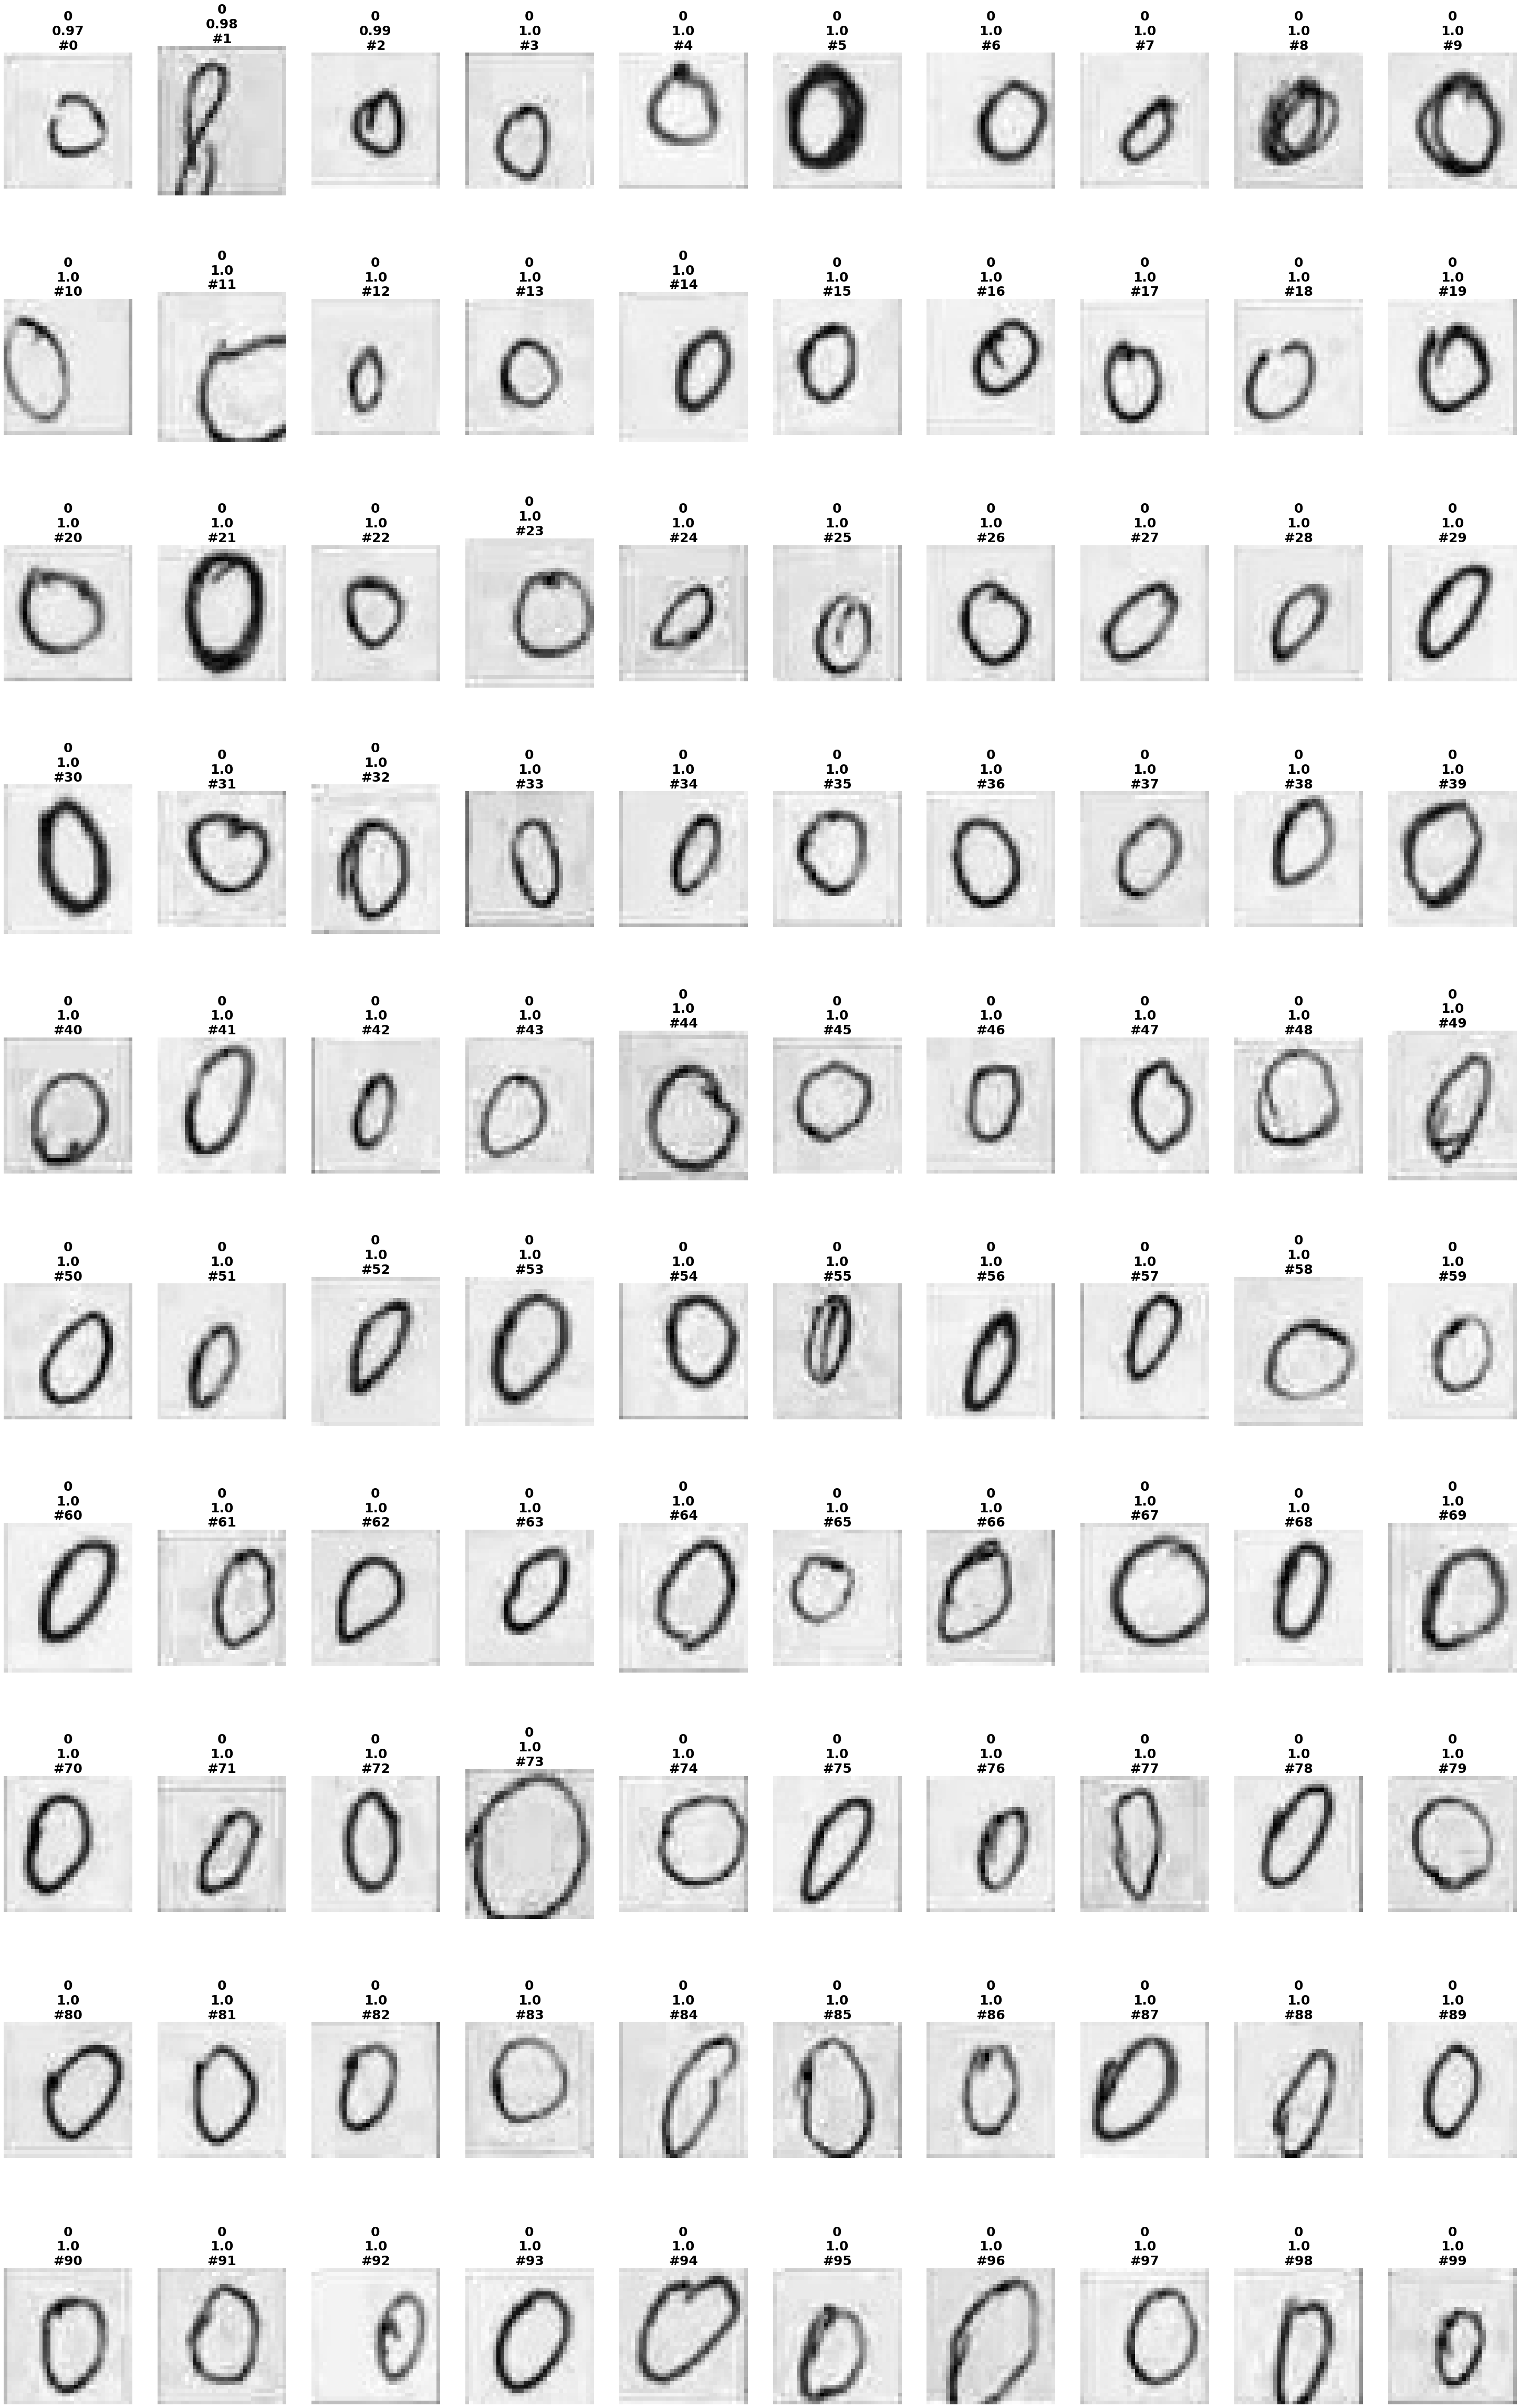

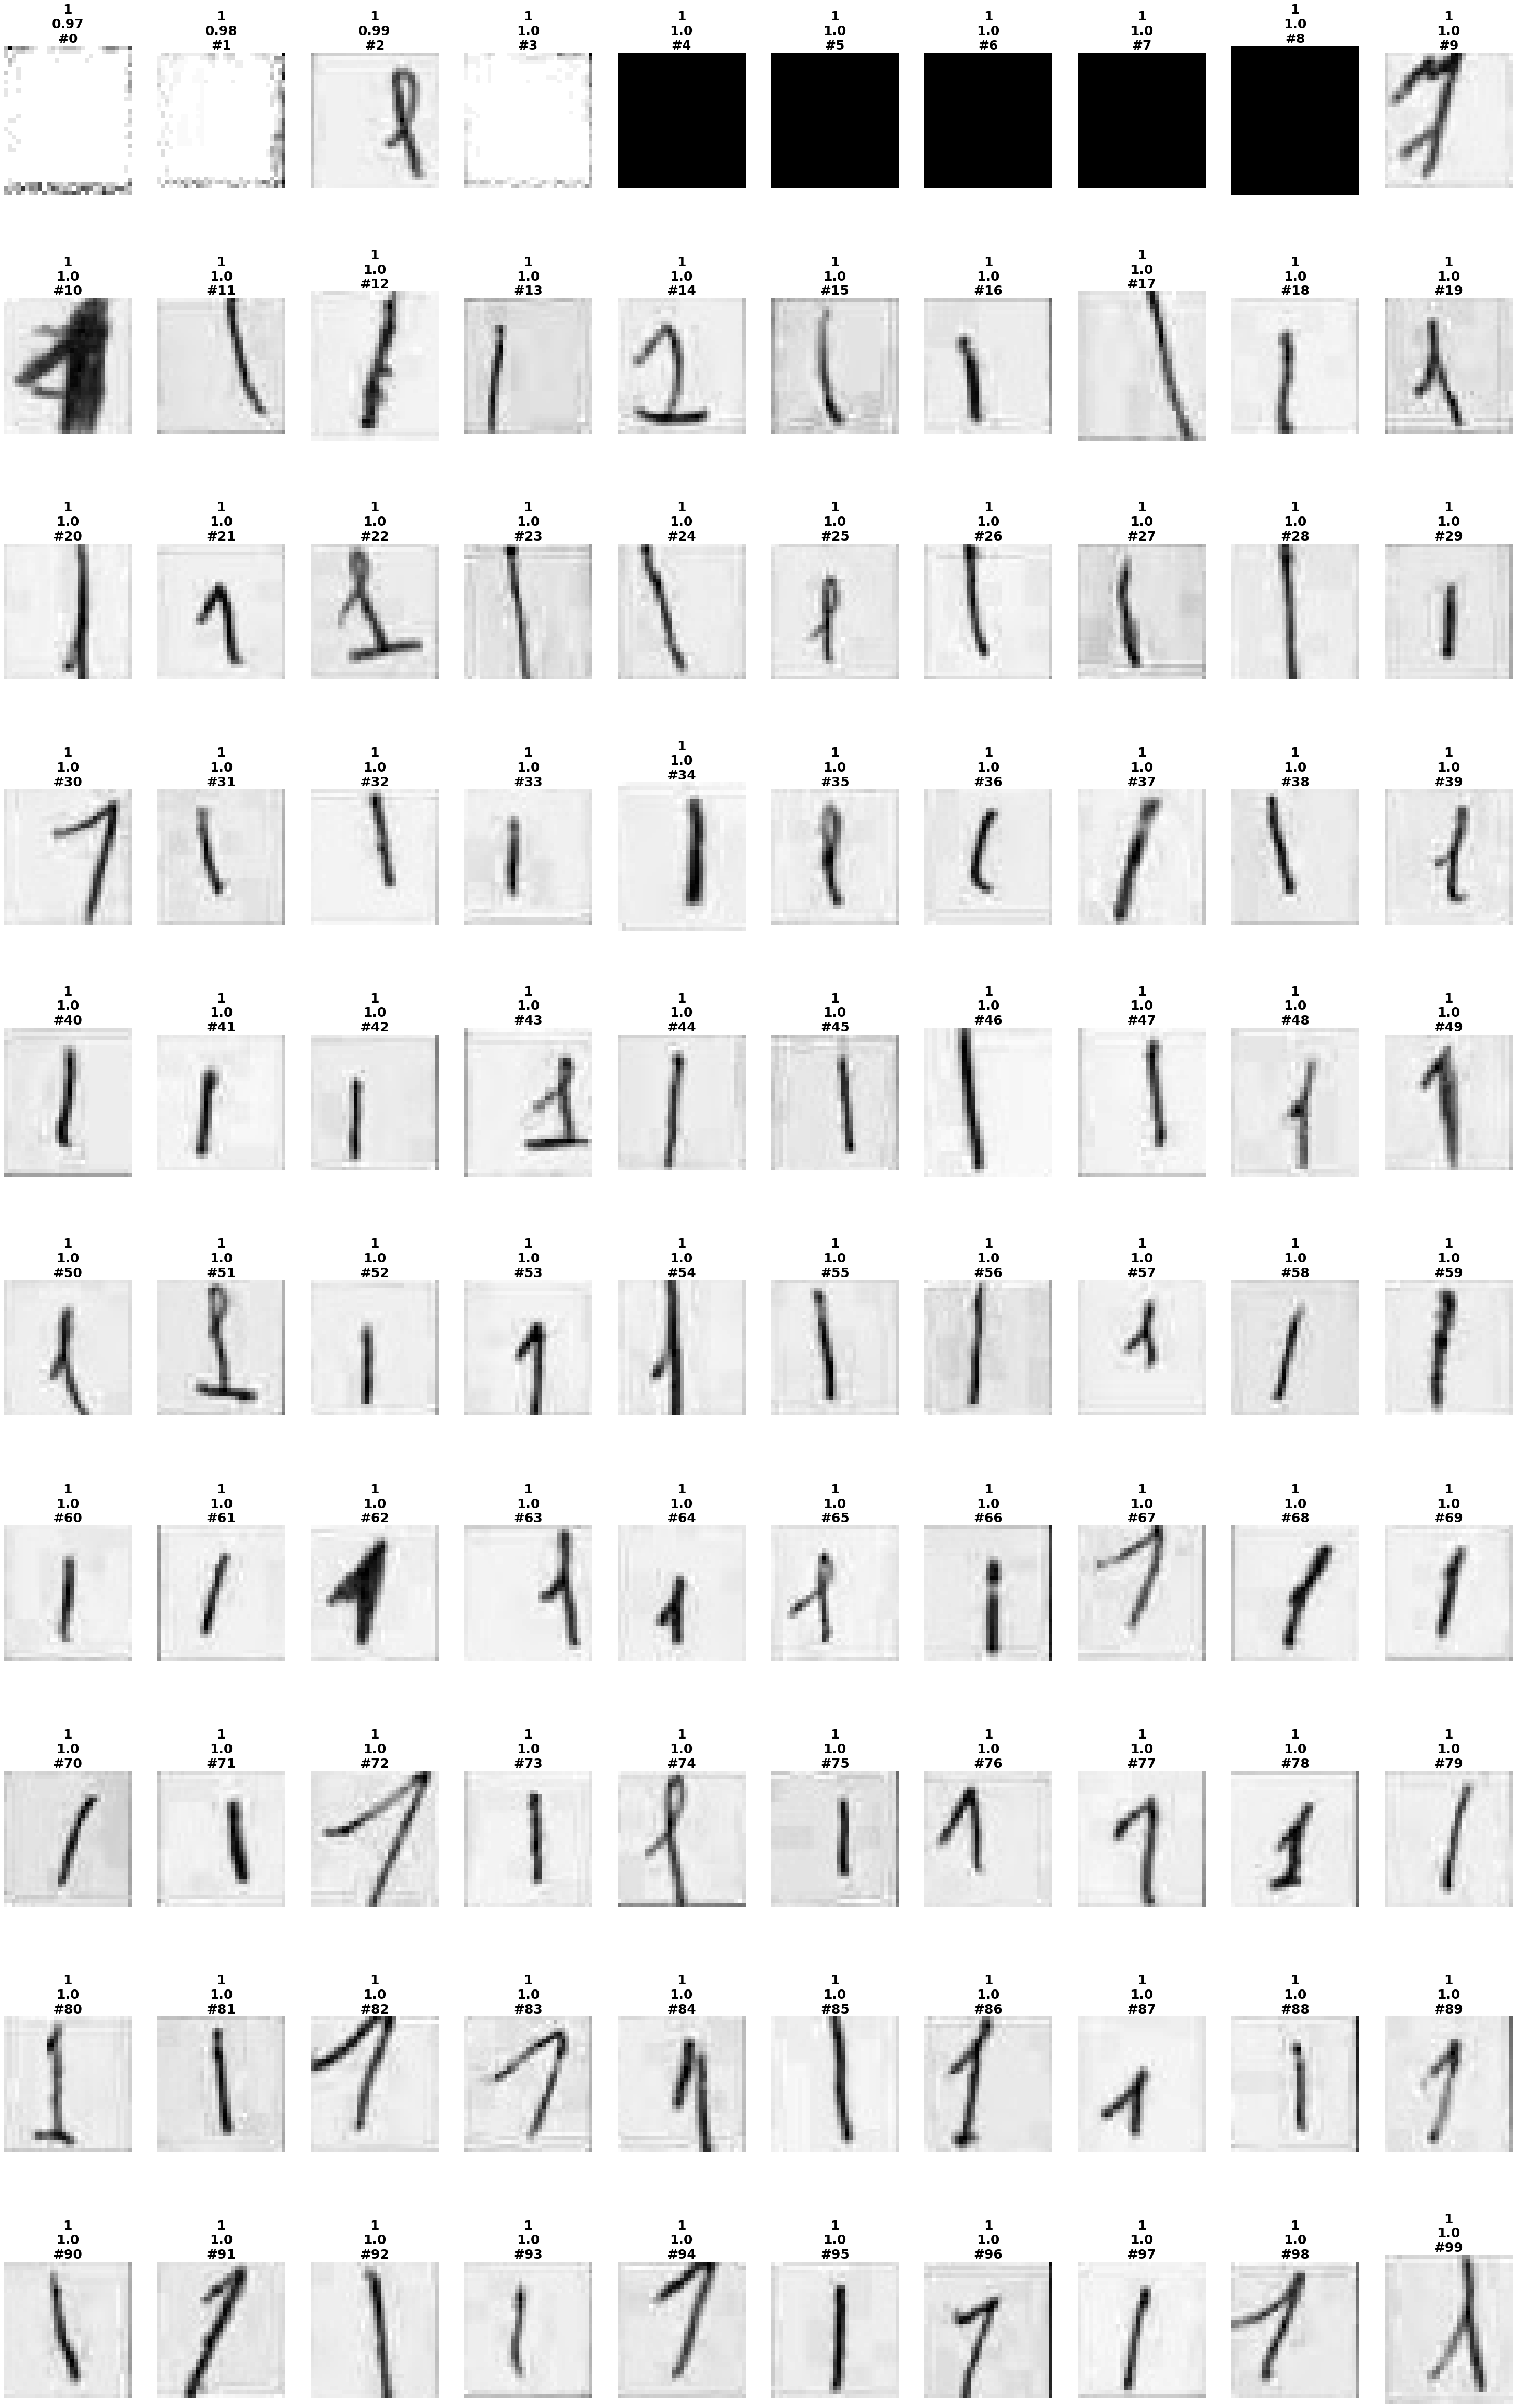

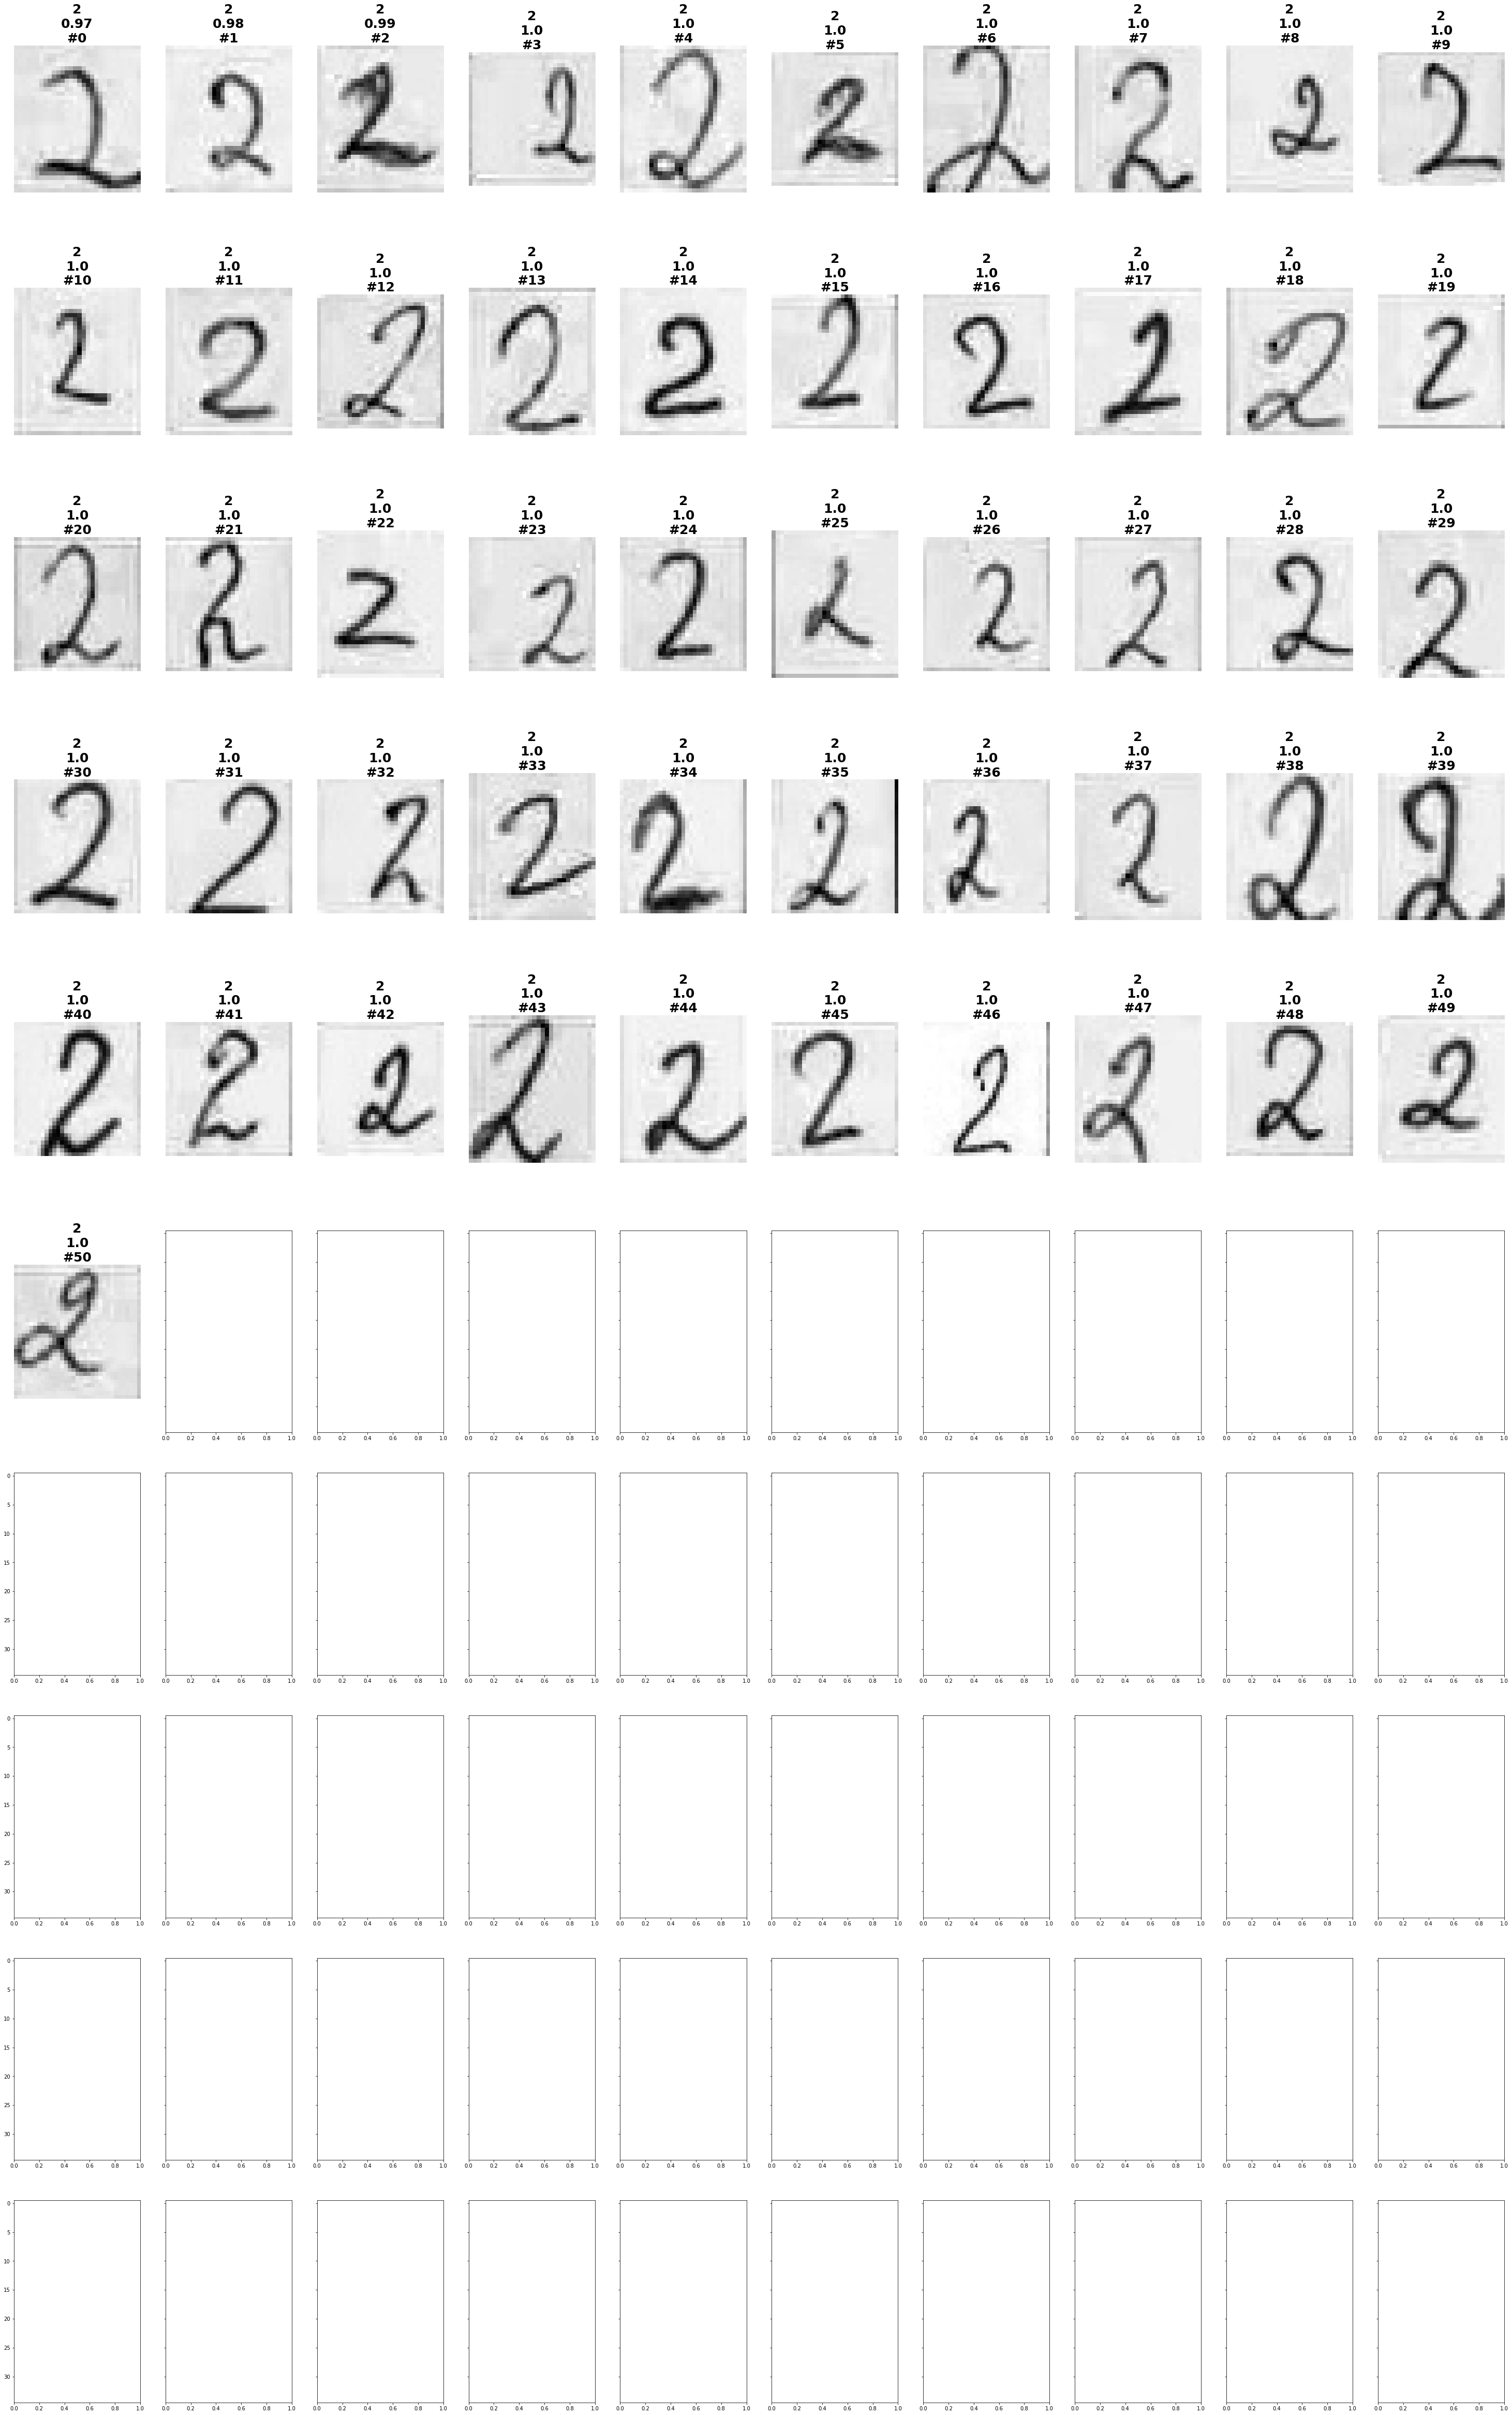

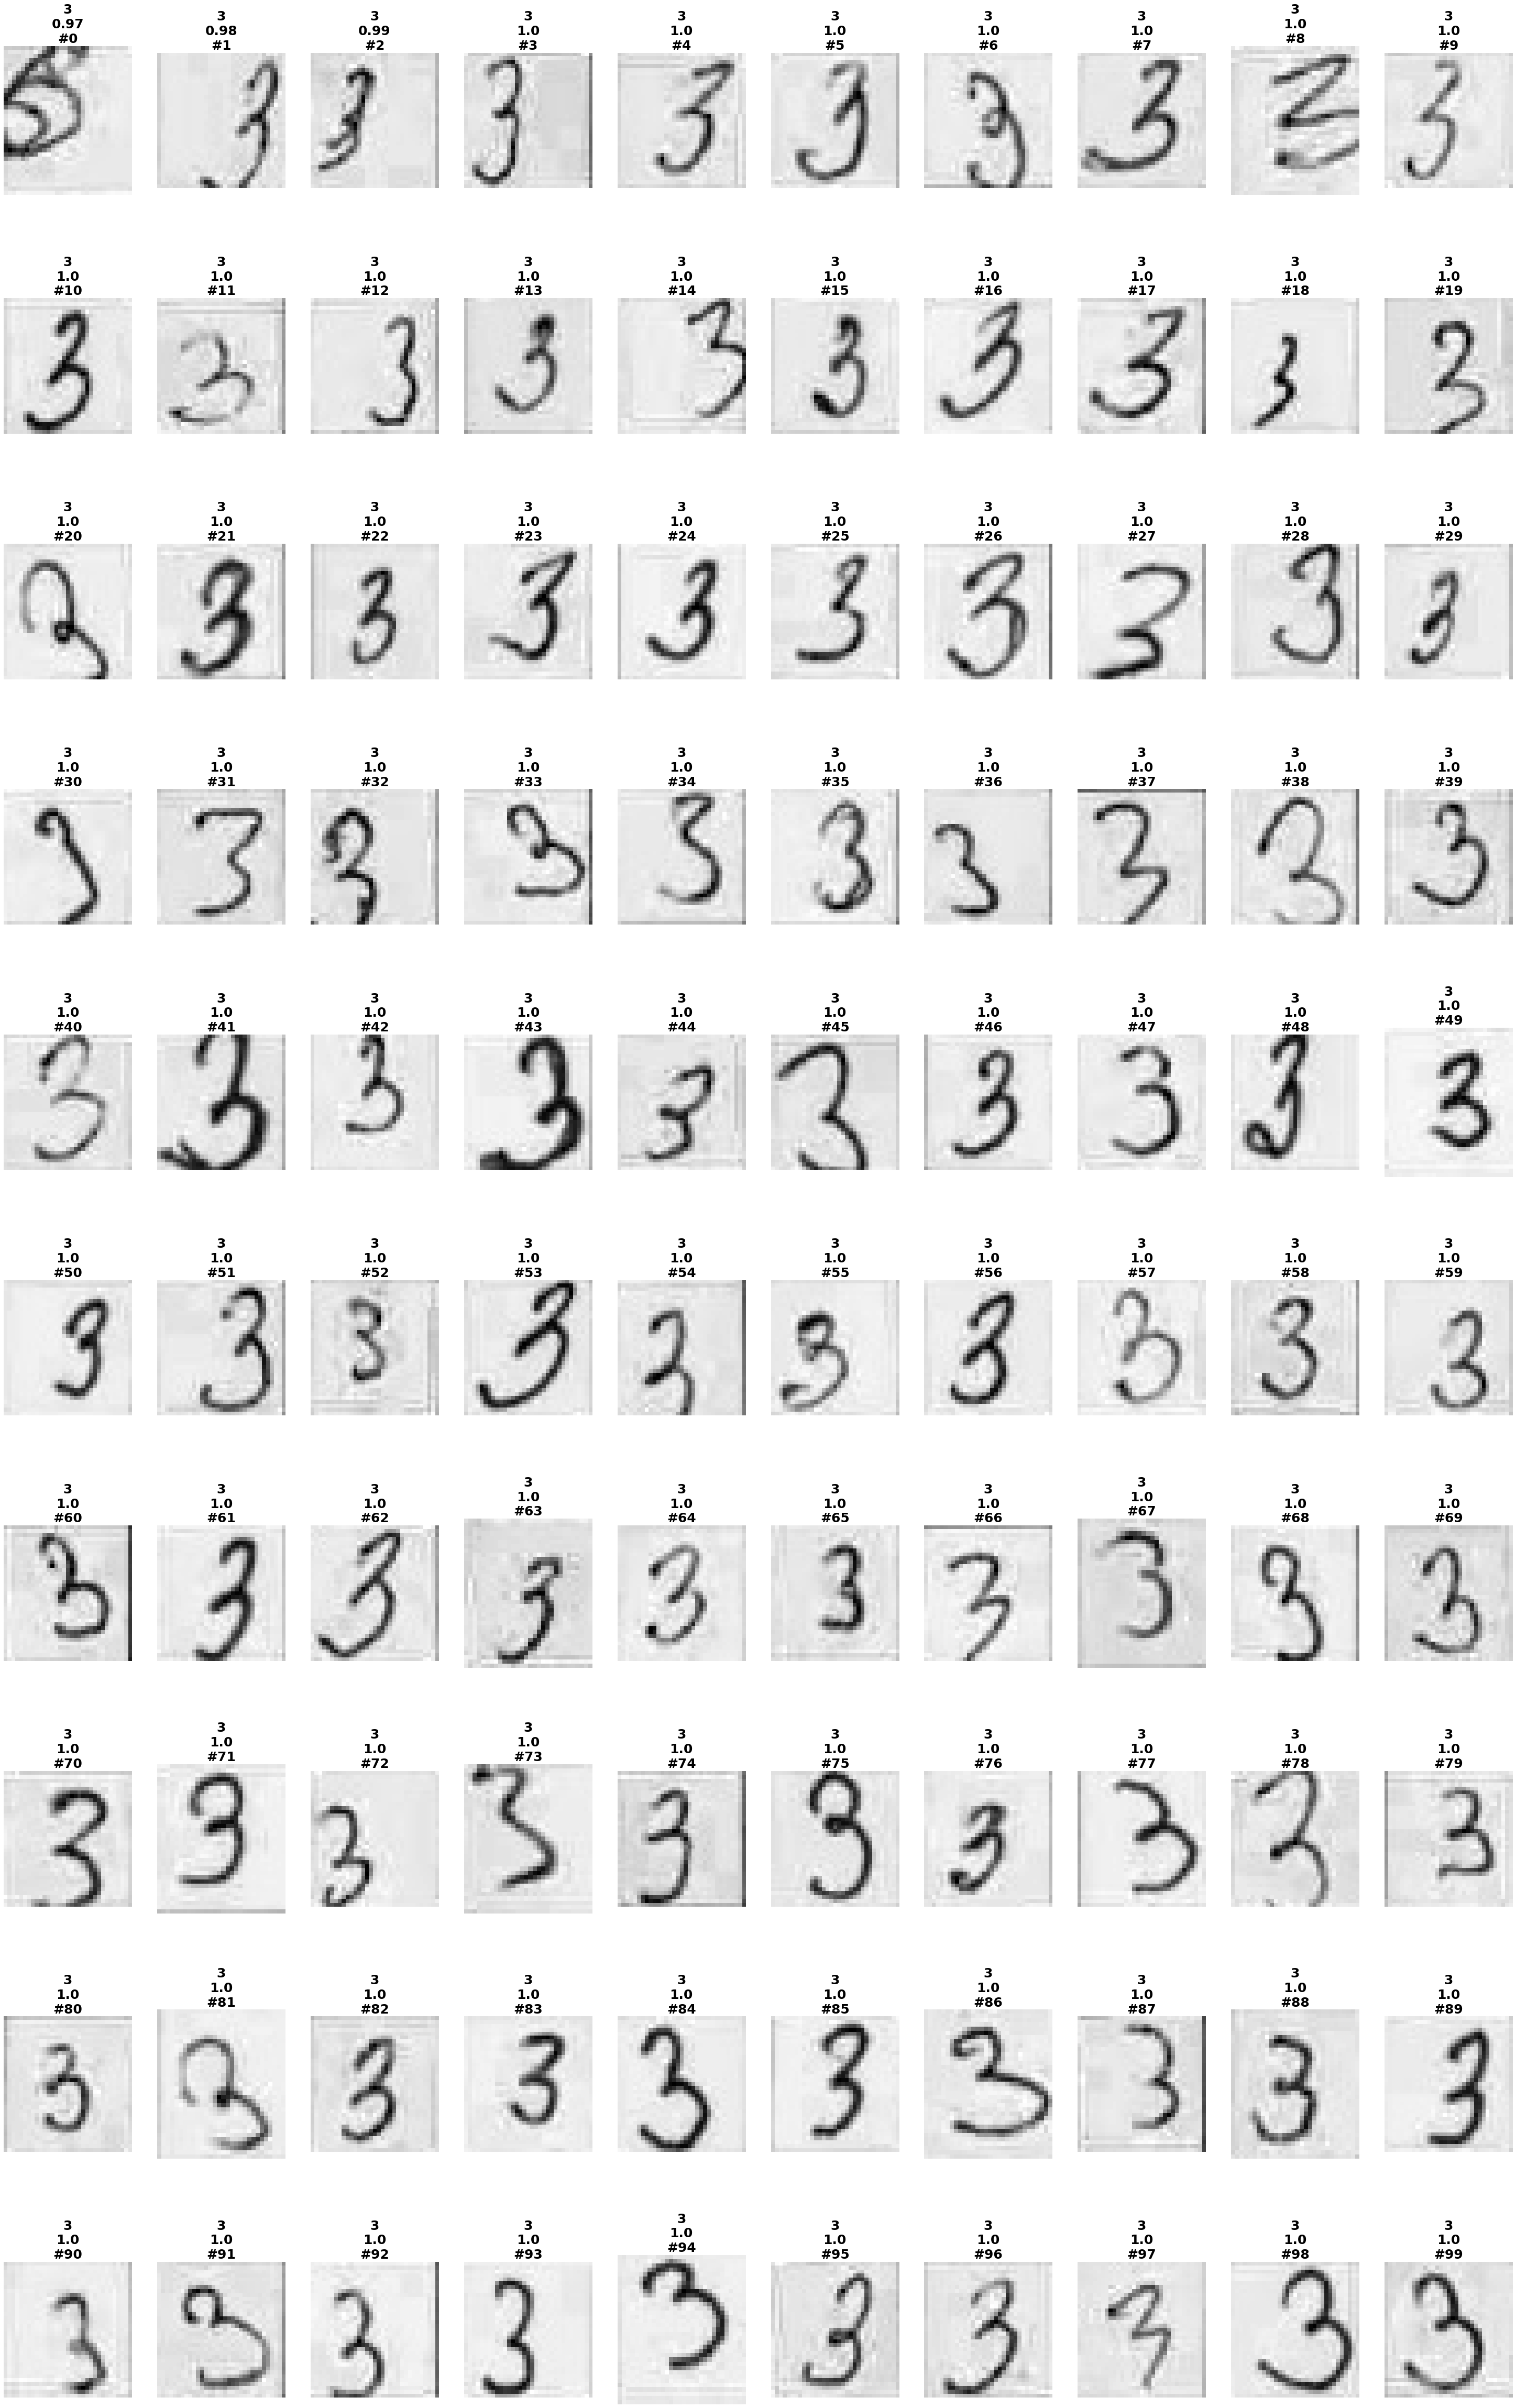

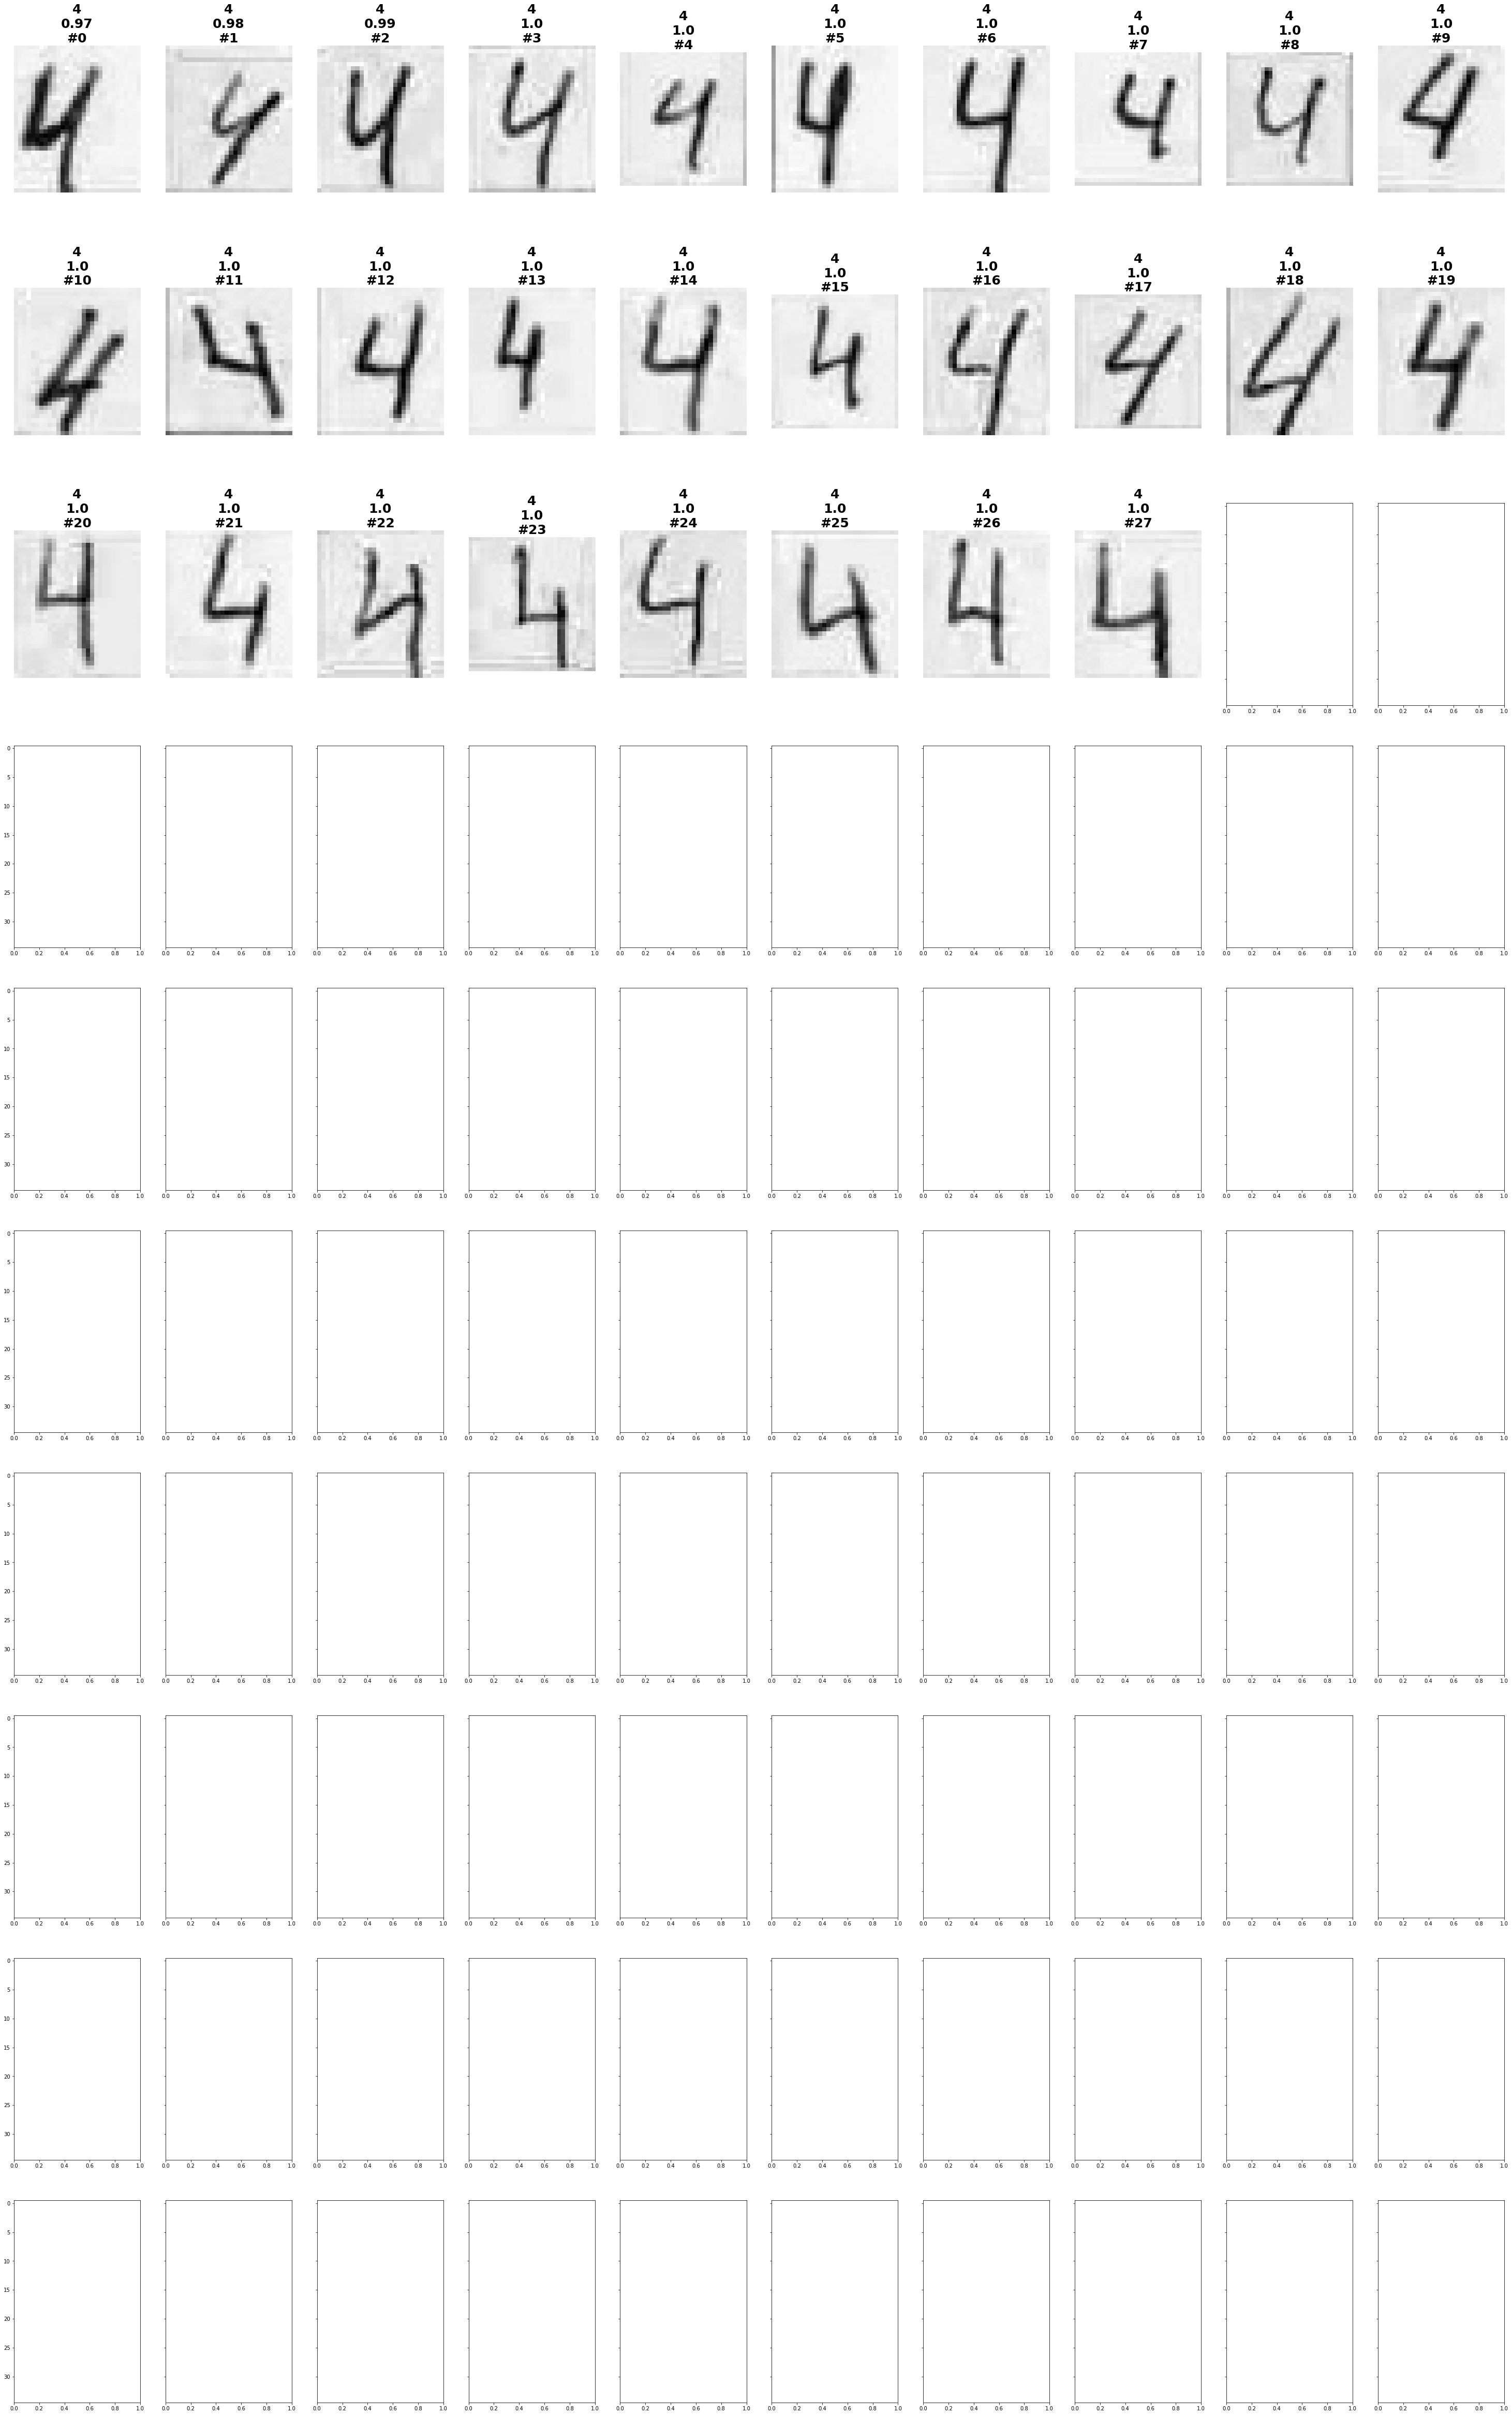

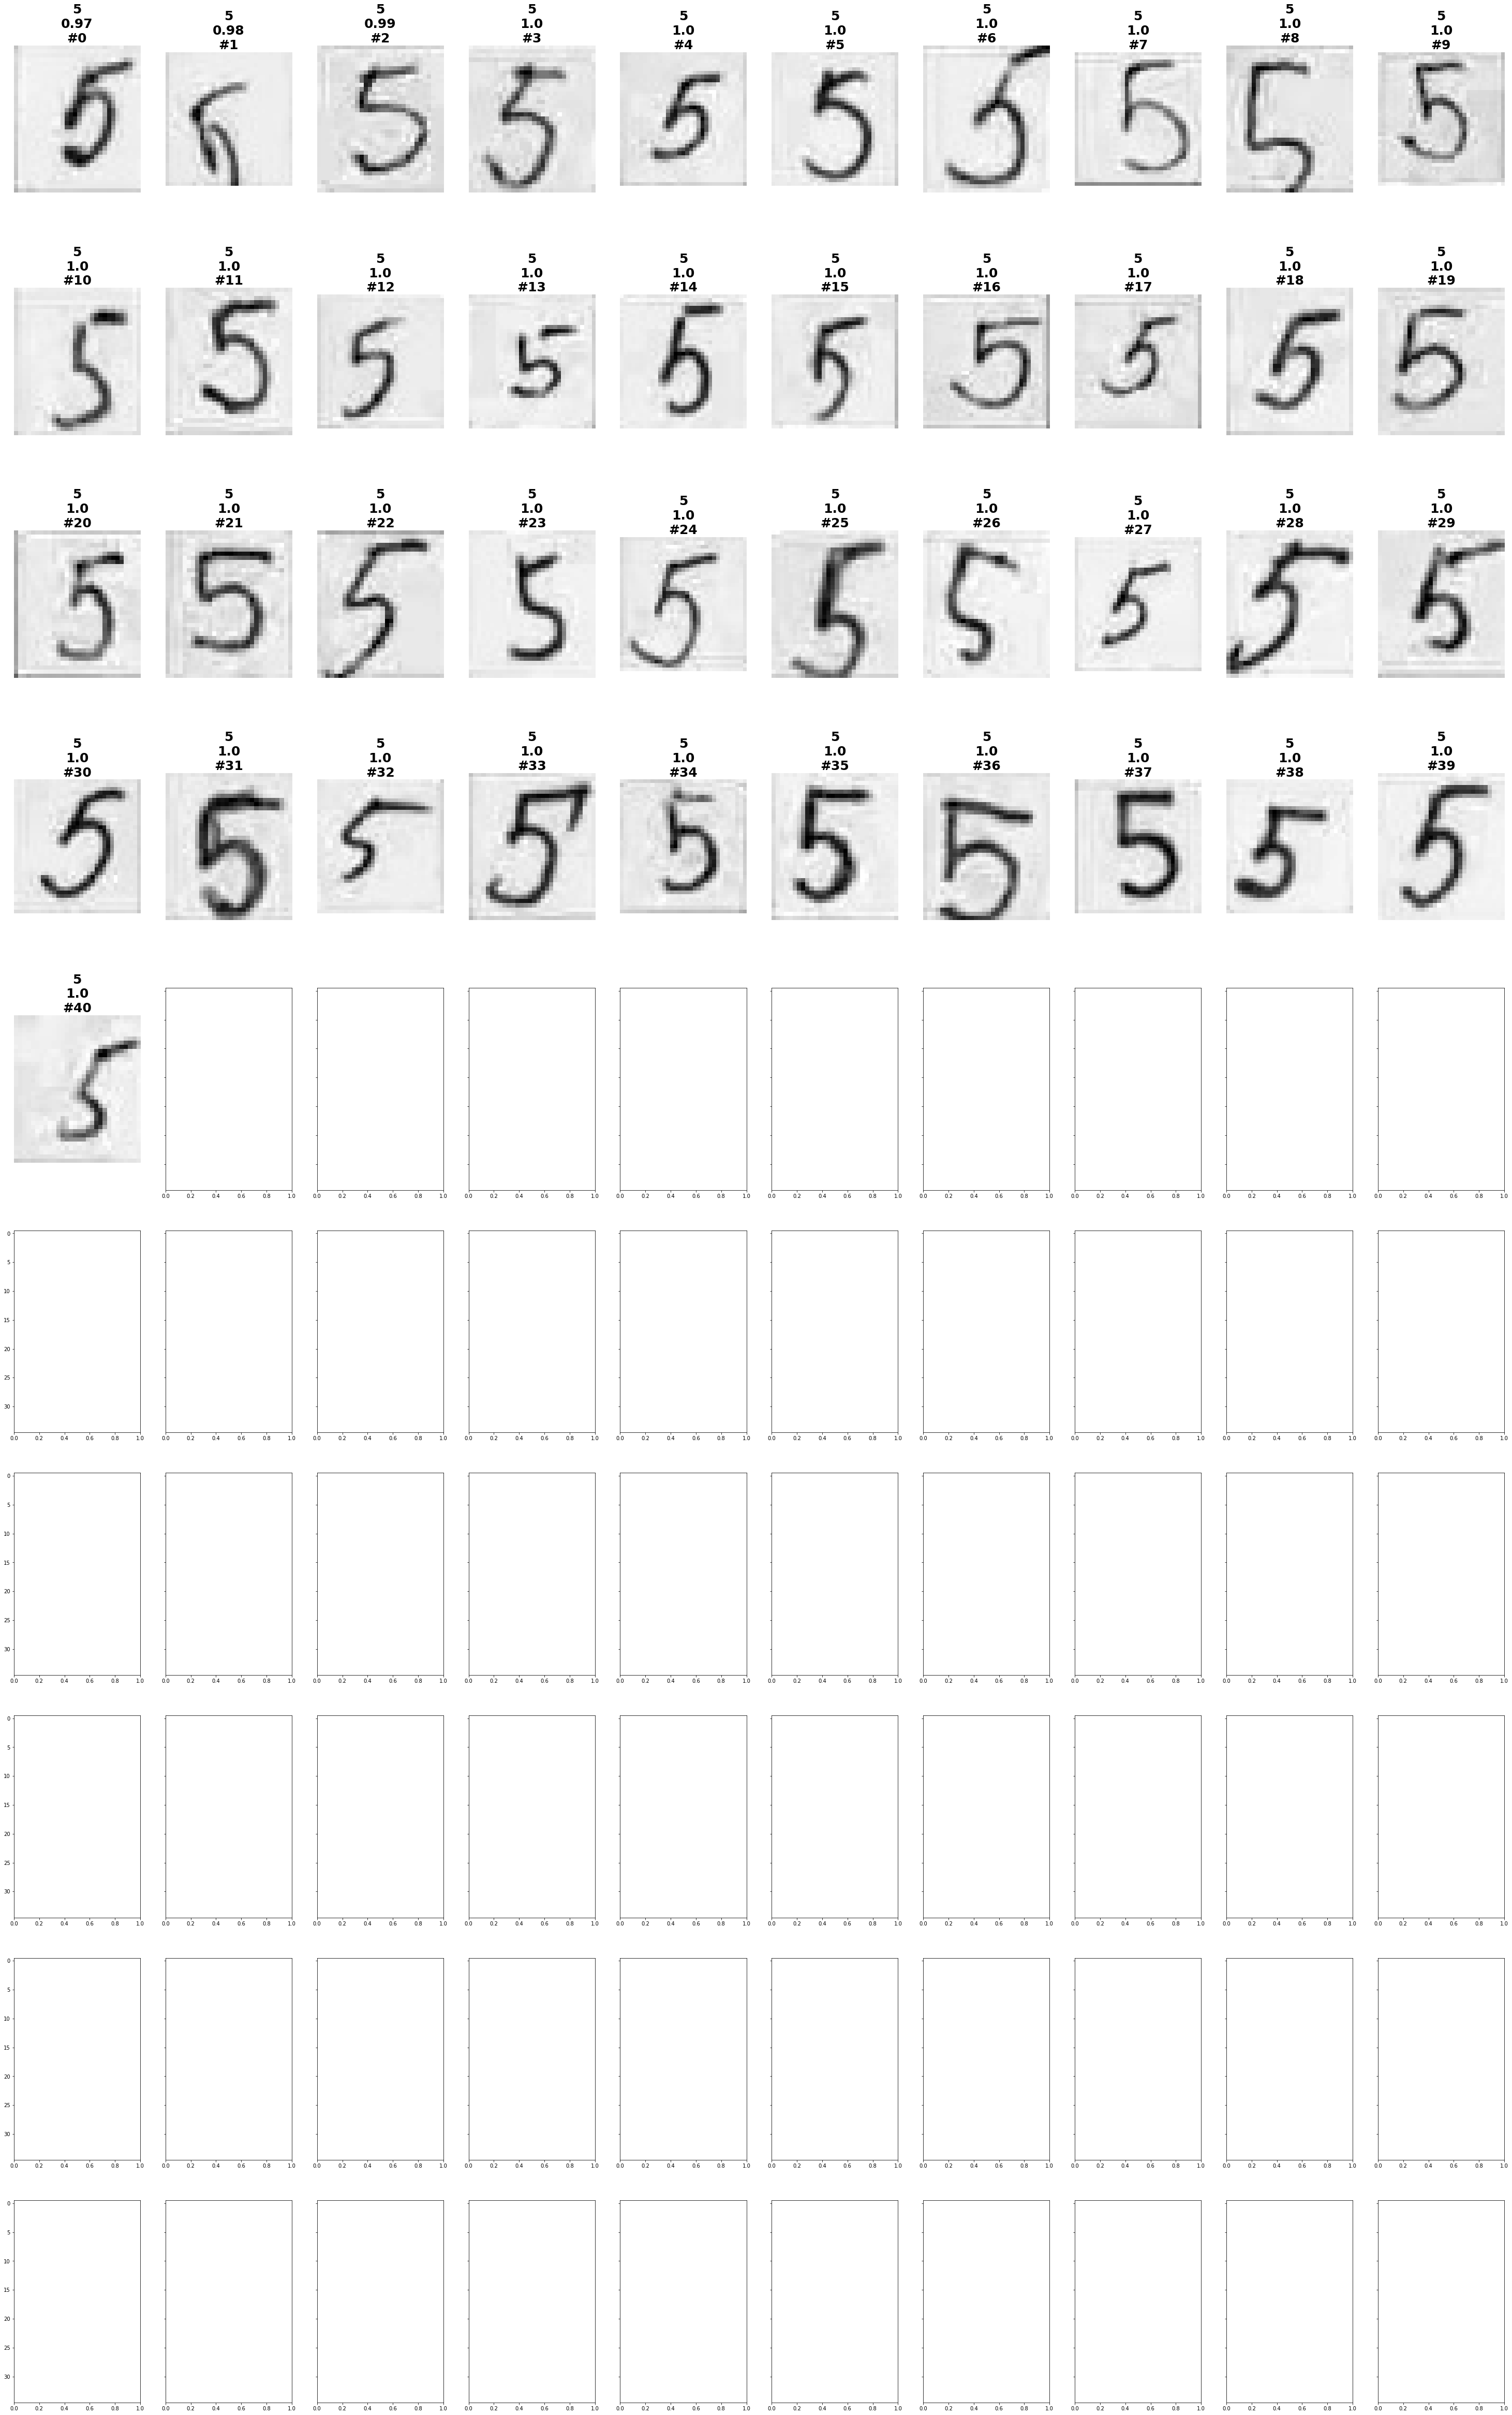

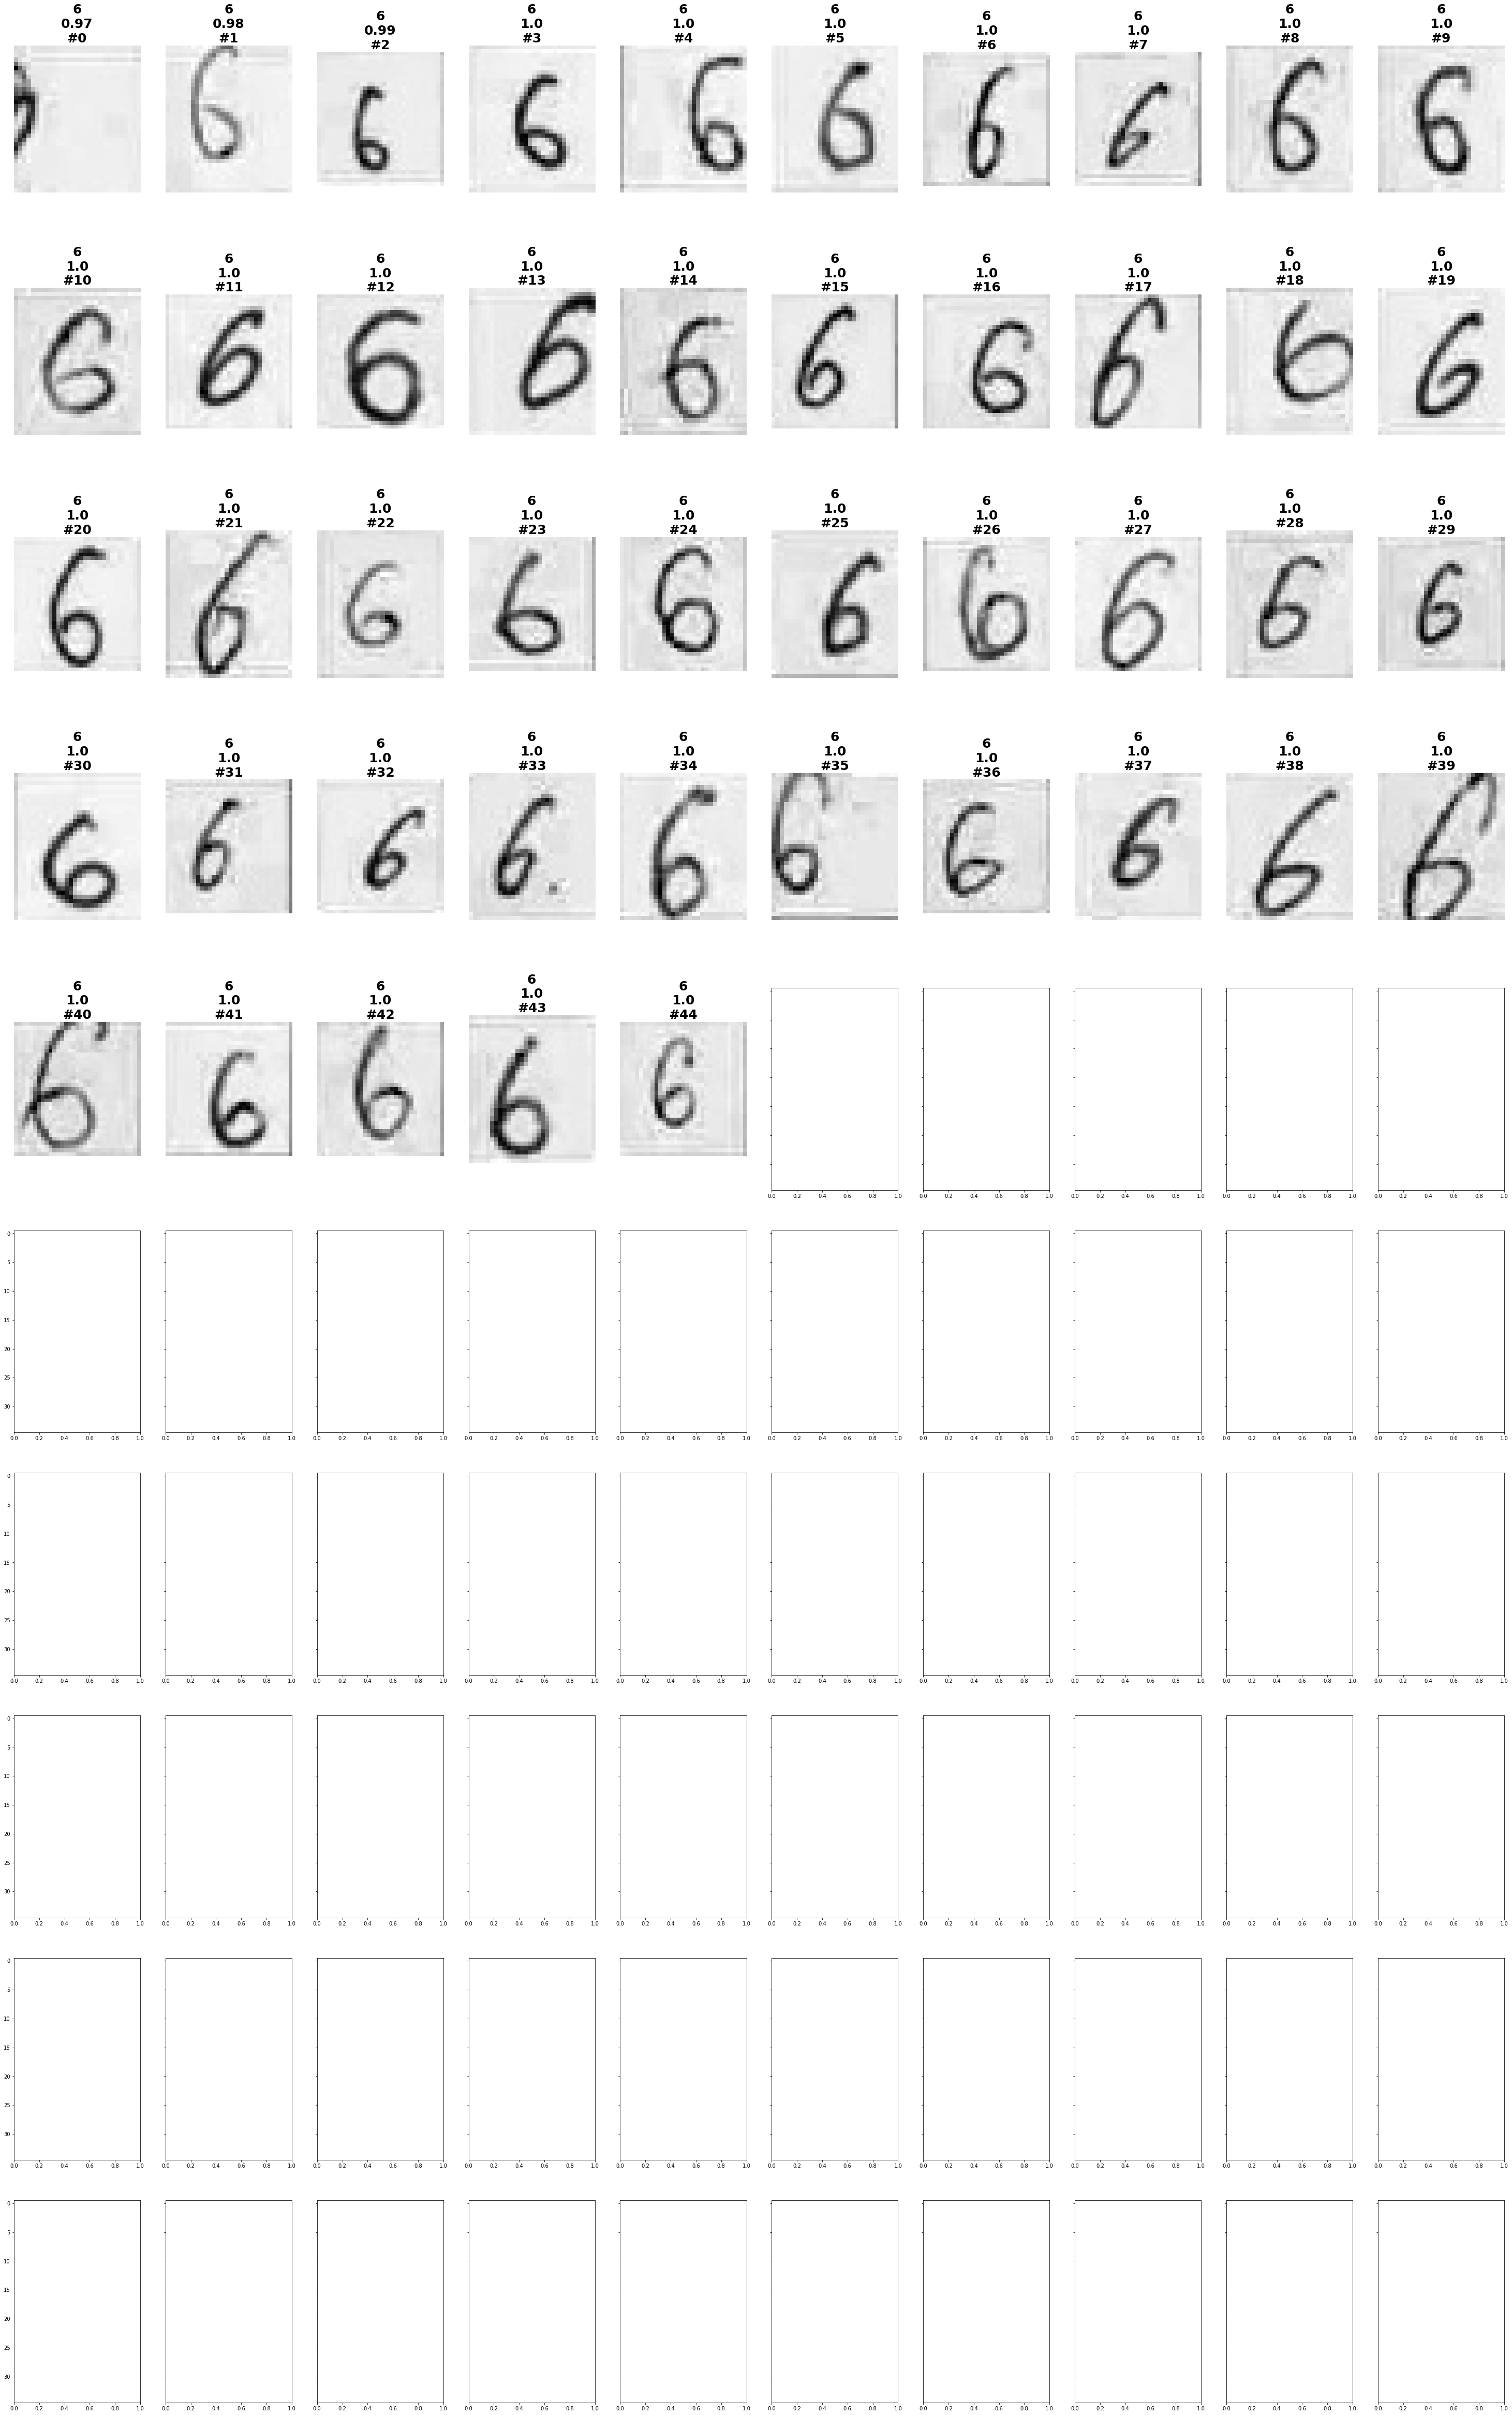

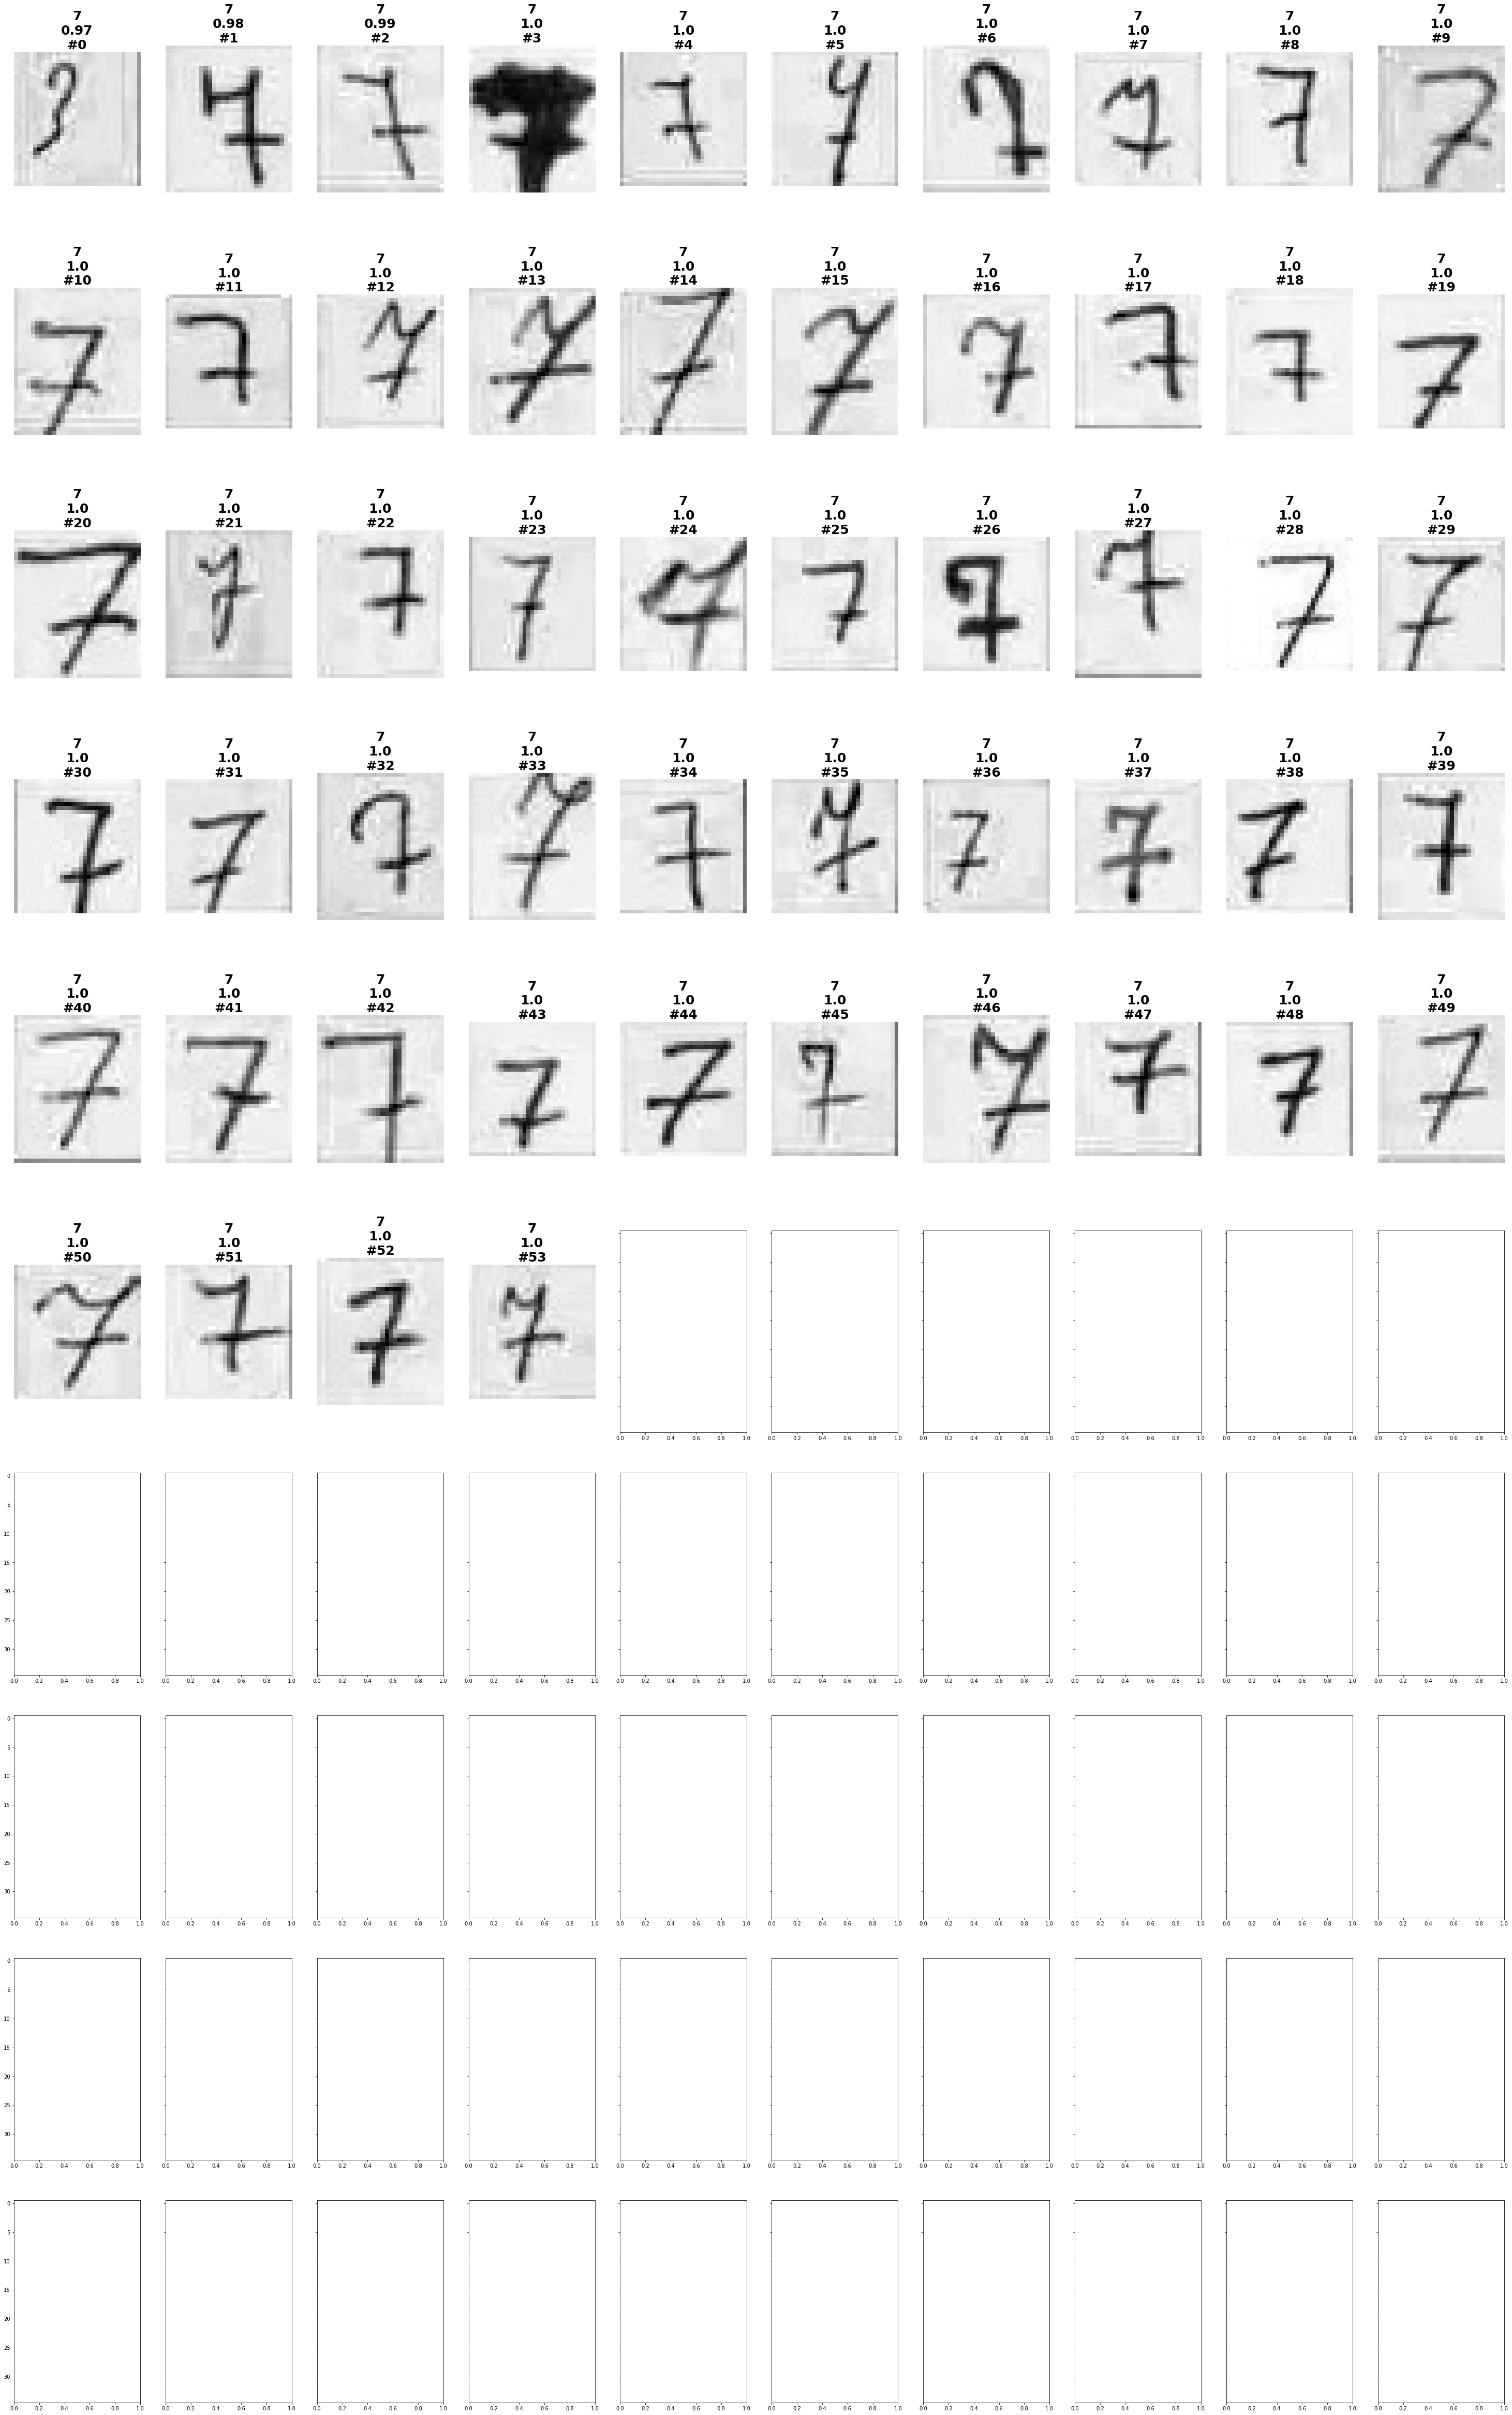

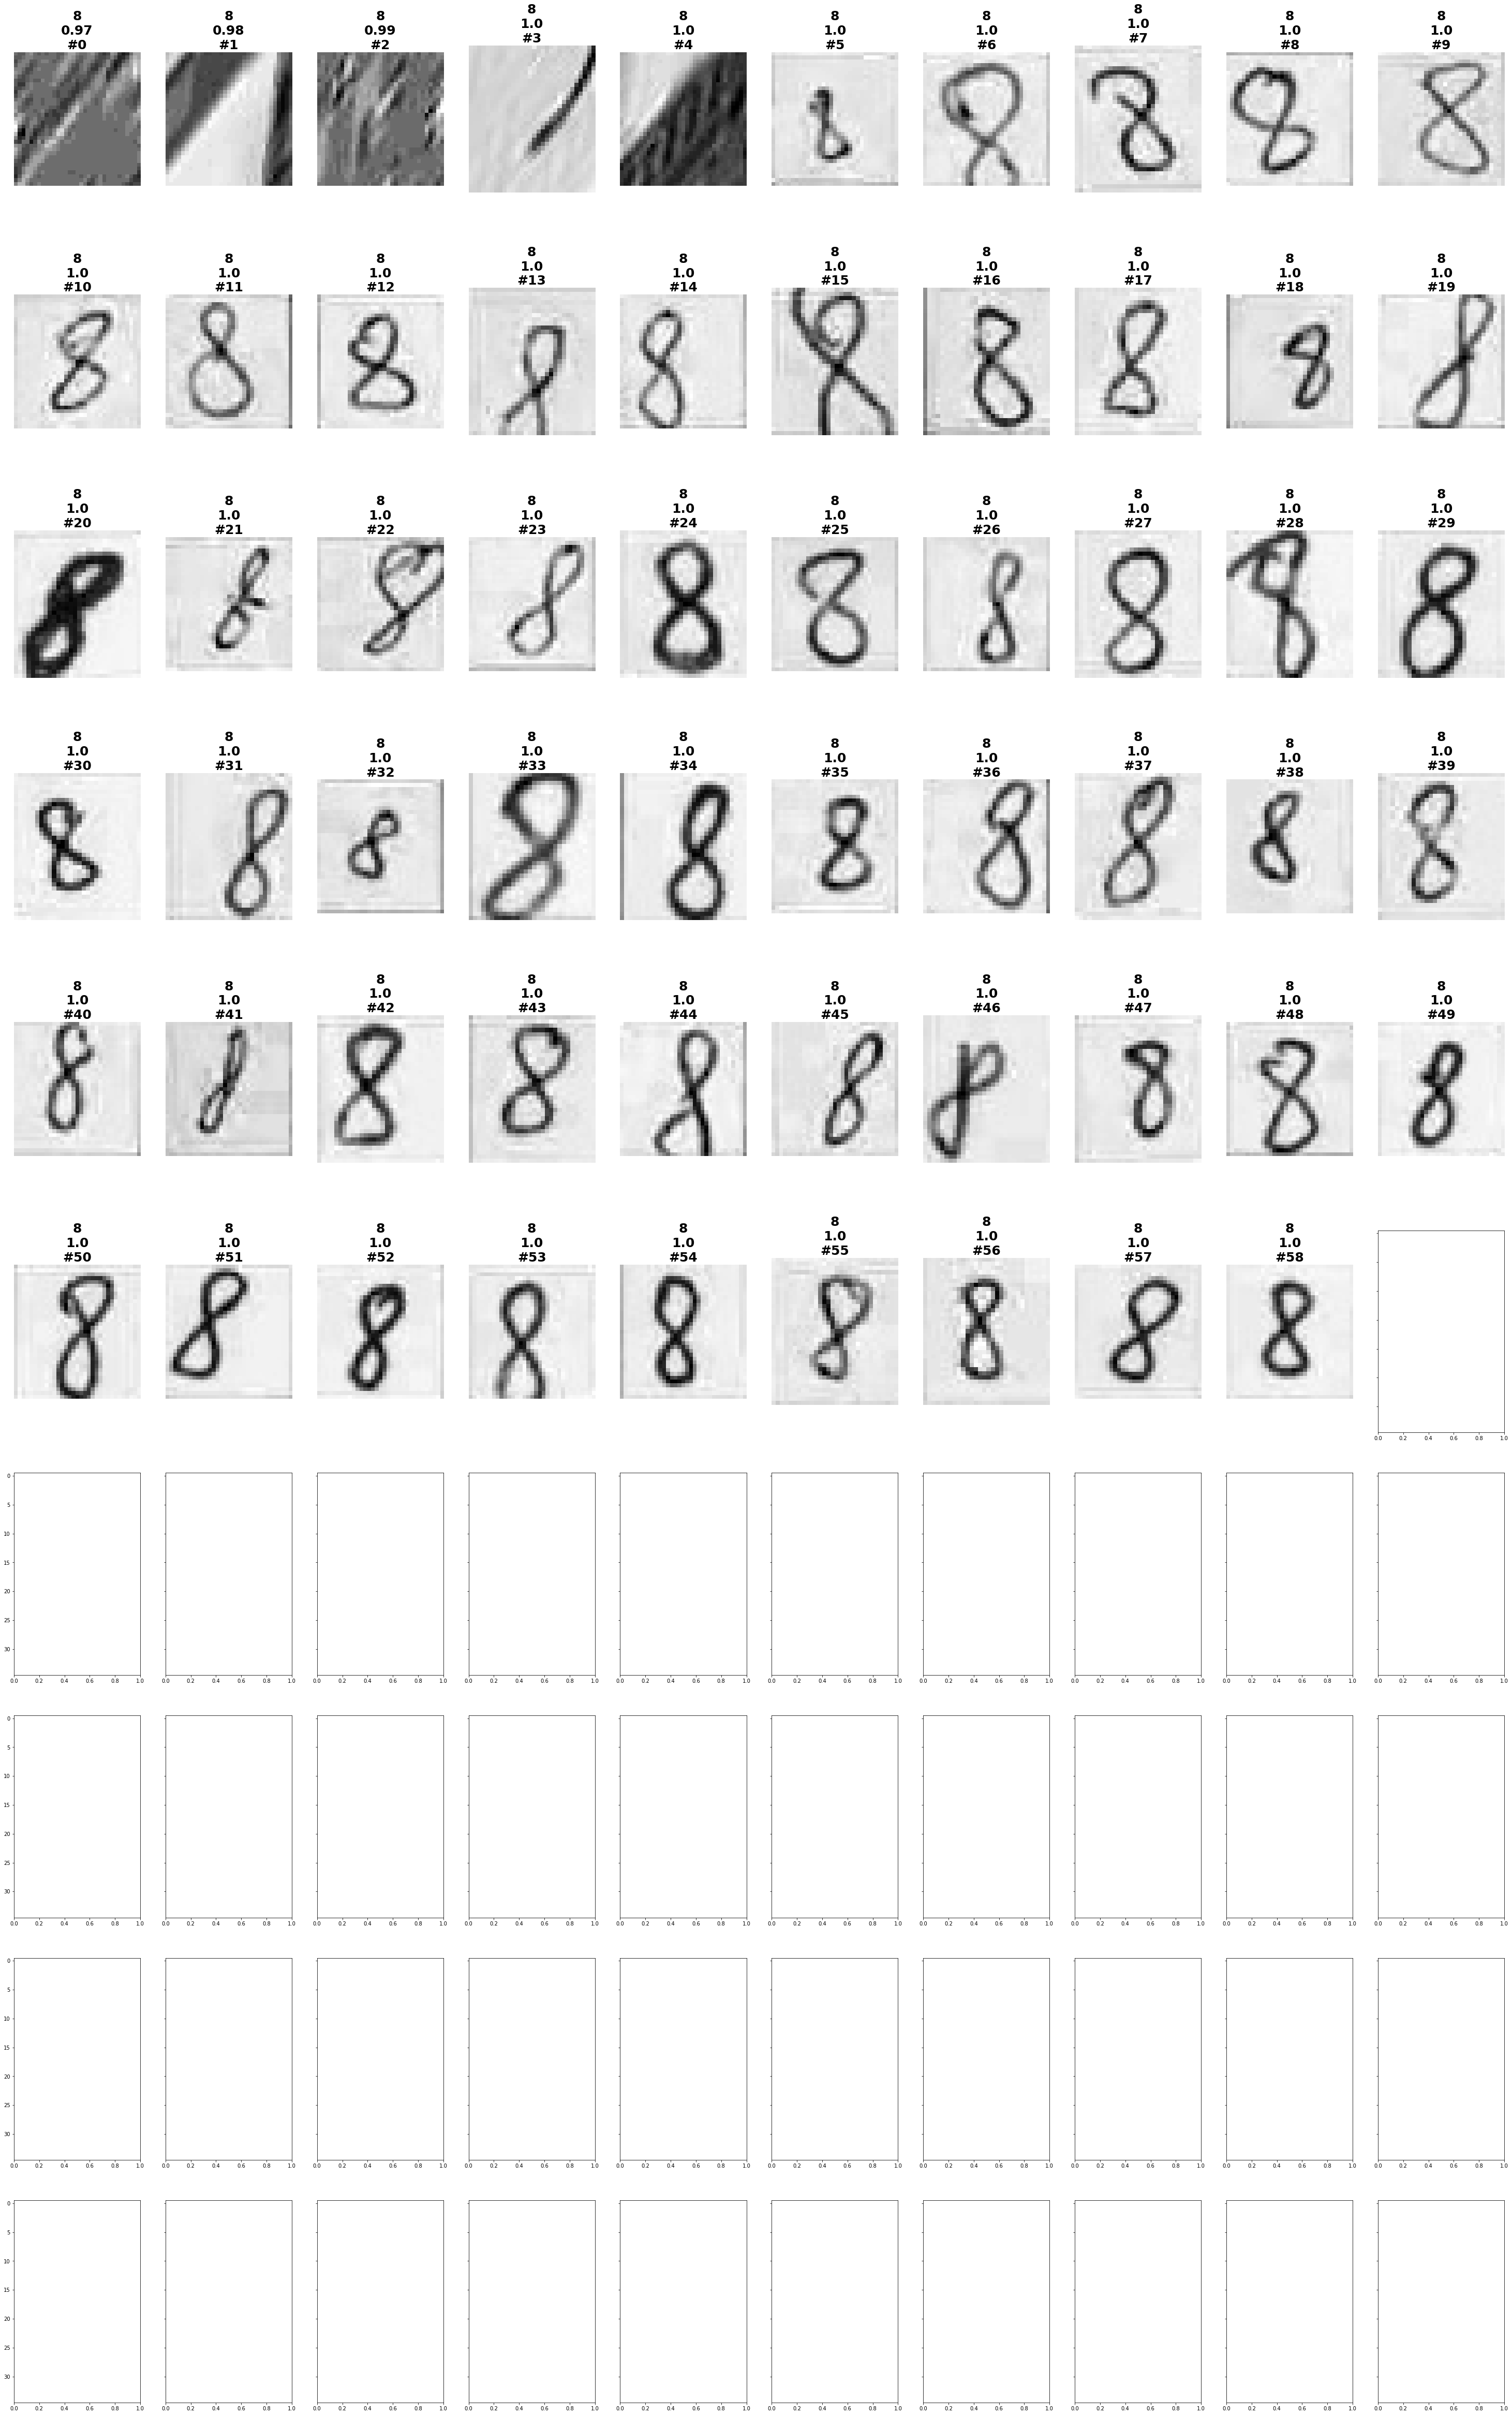

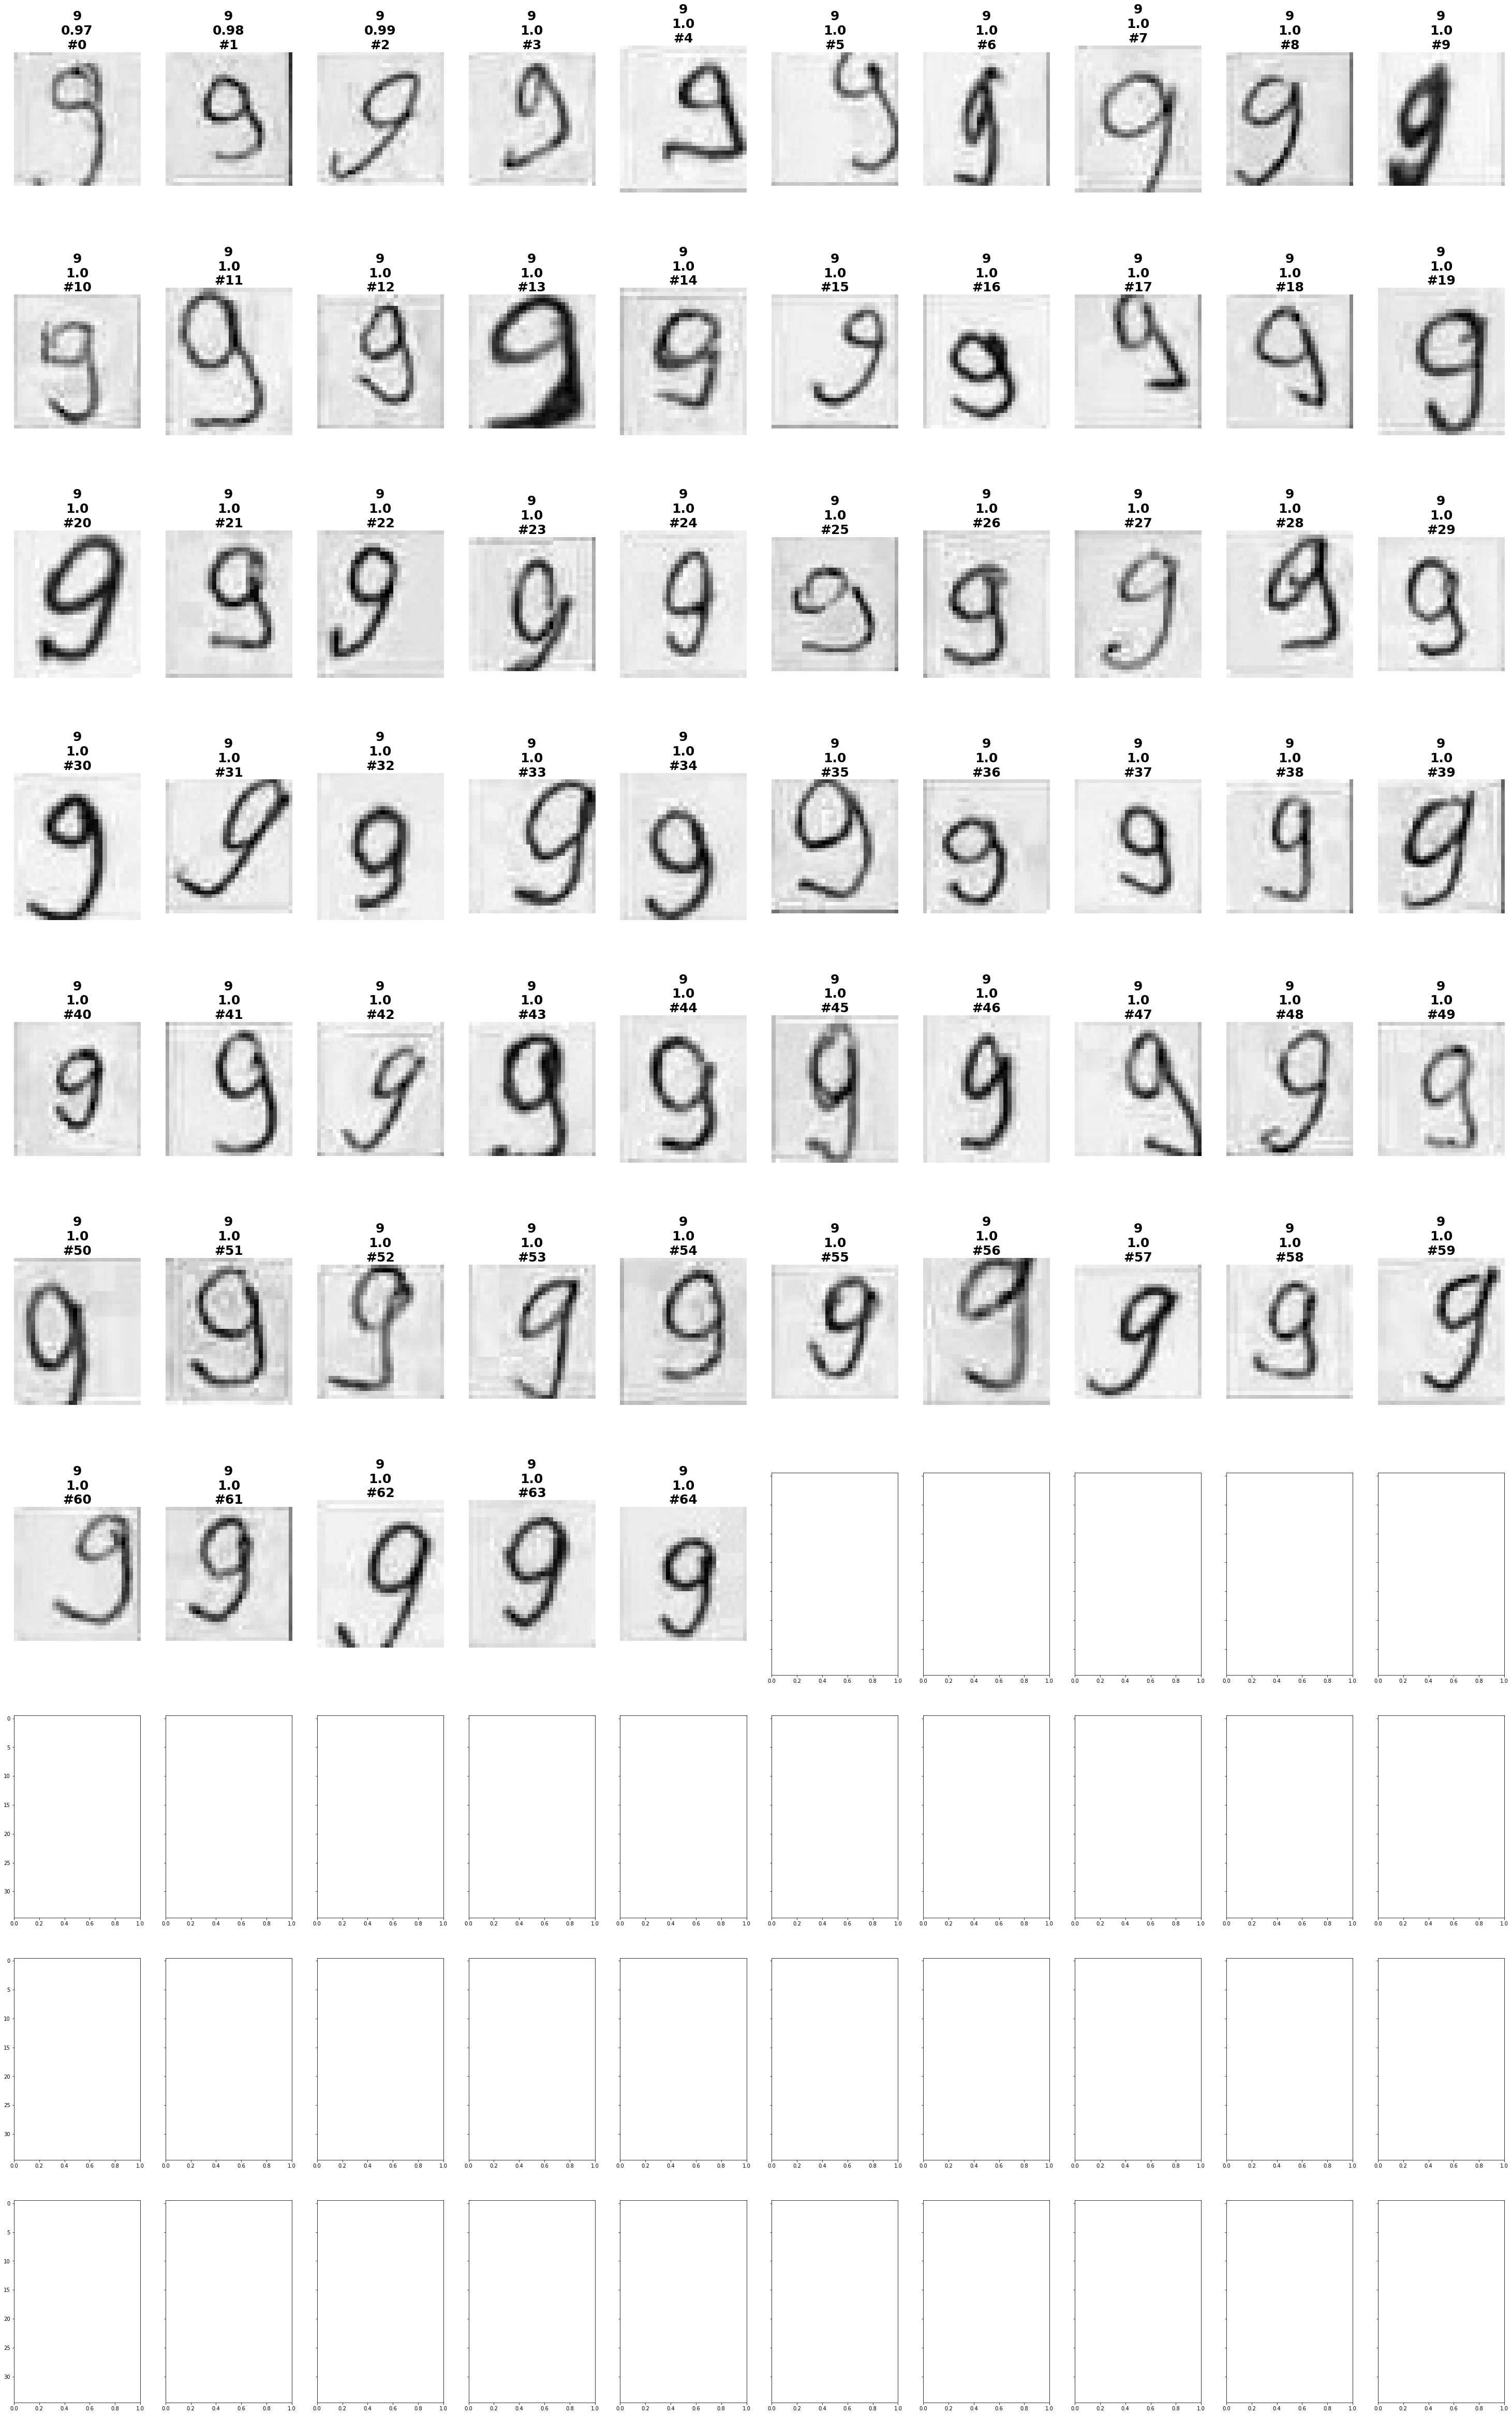

In [81]:
for d in range(10):
    temp_df = recognized_digits[recognized_digits["recognized_value"] == d]

    f, axes = plt.subplots(10, 10, sharey=True,figsize=(50, 80))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    for i,ax in enumerate(axes.flat):
        if i < temp_df.shape[0]:
            ax.axis('off')
            ax.imshow(temp_df.iloc[i]["digit_picture"],cmap="gray")
            subplot_title = "{}\n{}\n#{}".format(d, 
                                           round(recognized_digits.iloc[i]["confidence"], 2), i)
            ax.set_title(subplot_title, fontweight="bold",  fontsize=25)
    plt.savefig("recognized_by_digit/digit_{}.pdf".format(d))

0
1
2
3
4
5
6
7
8
9


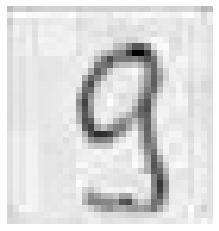

In [20]:
for d in range(10):
    print(d)
    temp_df = recognized_digits[recognized_digits["recognized_value"] == d]

    
    for i,ax in enumerate(axes.flat):
        if i < temp_df.shape[0]:
            subplot_title = "{}_#{}_{}".format(d,i, rand_line())
            plt.axis('off')
            plt.imshow(temp_df.iloc[i]["digit_picture"],cmap="gray")
            plt.savefig("recognized_by_digit/by_value/{}.png".format(subplot_title))
            
            
            
    

3 0.9998822


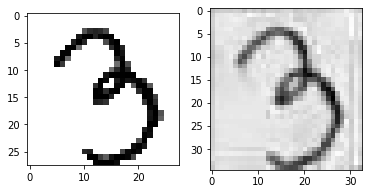

1 0.9853489


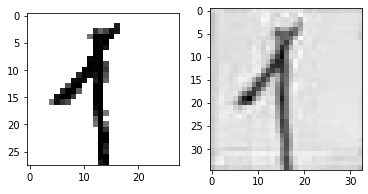

1 1.0


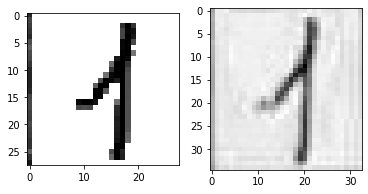

0 1.0


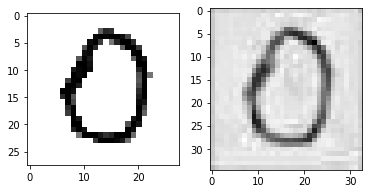

4 0.99415004


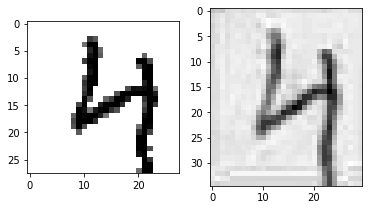

3 1.0


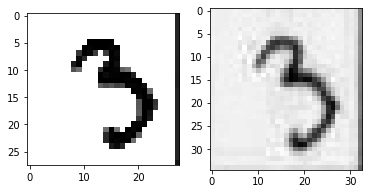

1 0.9843413


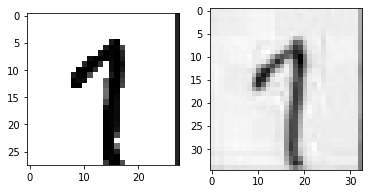

0 0.99999547


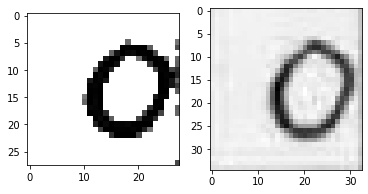

4 0.999928


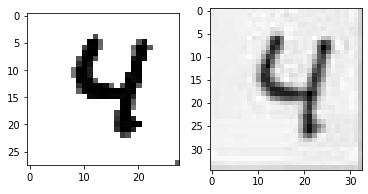

6 0.99976915


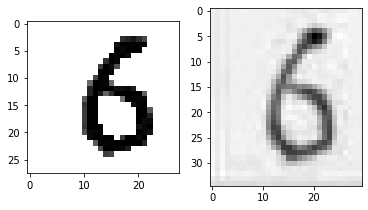

3 1.0


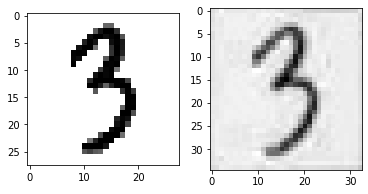

3 0.99999976


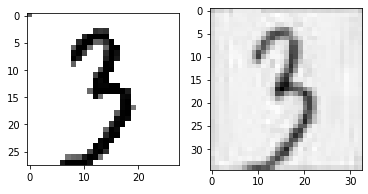

0 0.9379511


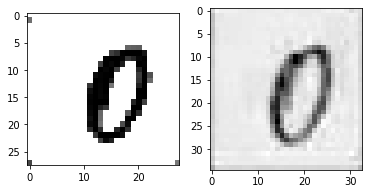

5 0.9357669


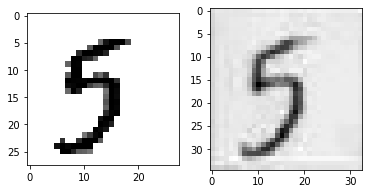

3 0.9999993


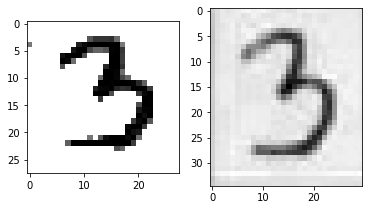

3 1.0


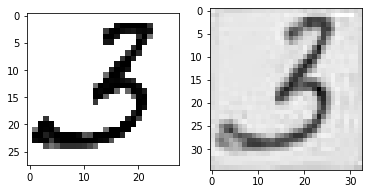

3 0.9999995


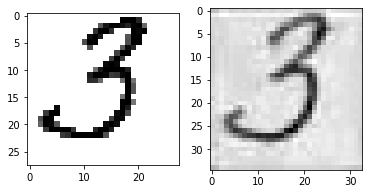

0 1.0


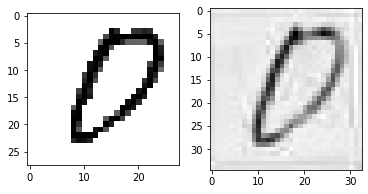

9 0.99571484


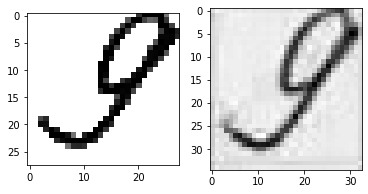

0 0.99999034


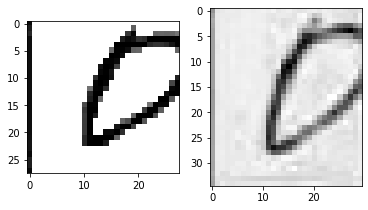

3 0.99998844


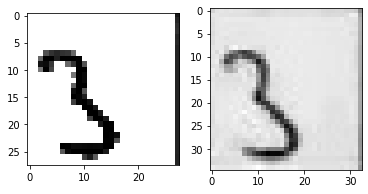

1 1.0


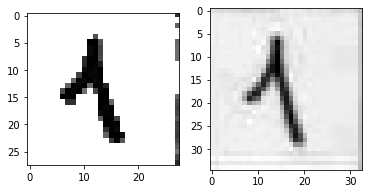

0 0.99994254


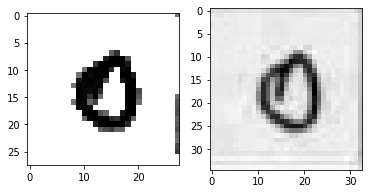

6 0.9999993


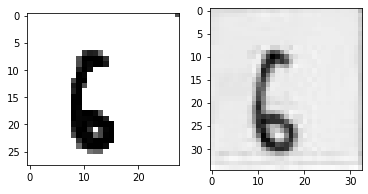

8 0.9996742


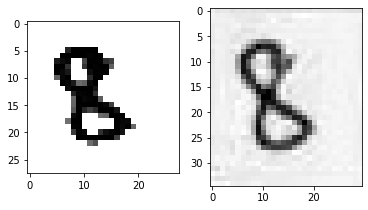

3 1.0


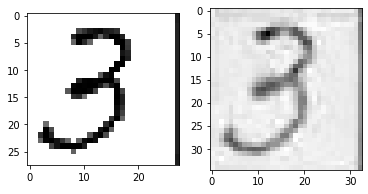

3 1.0


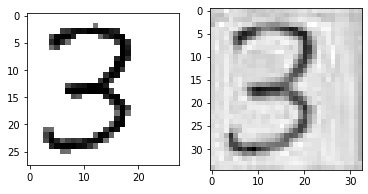

0 1.0


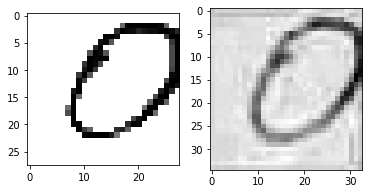

3 0.75499654


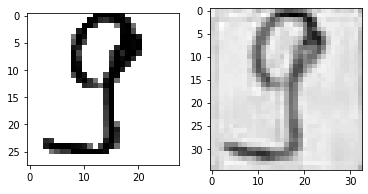

2 0.92884046


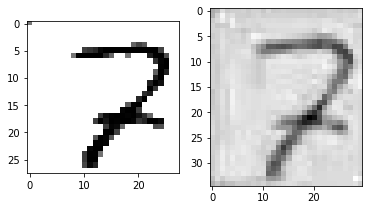

3 1.0


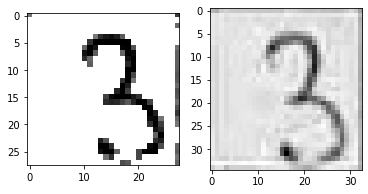

3 1.0


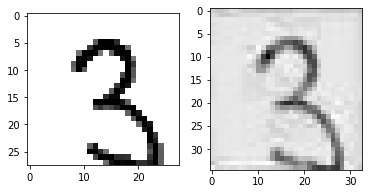

1 1.0


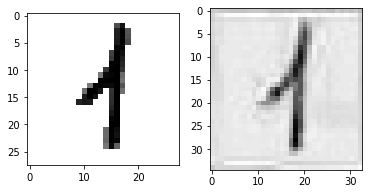

9 0.99999964


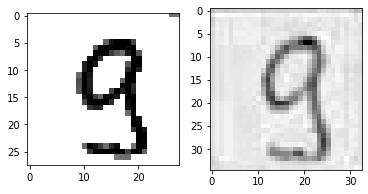

1 0.99998593


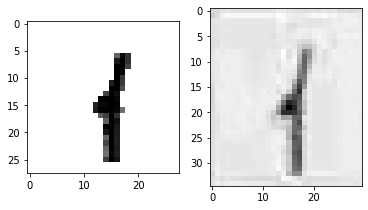

3 0.9982255


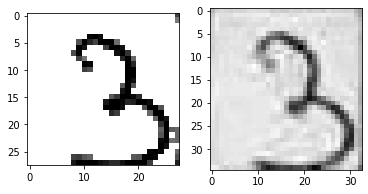

1 1.0


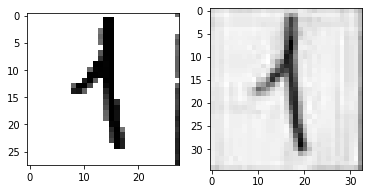

0 0.9999429


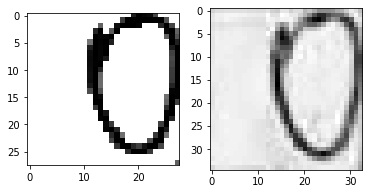

6 0.99999976


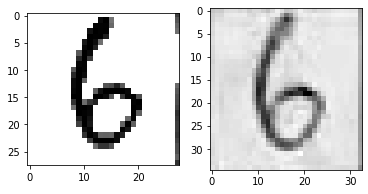

5 1.0


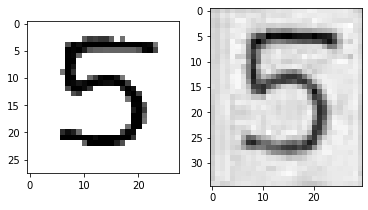

1 0.99910885


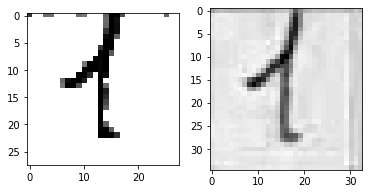

1 0.99999106


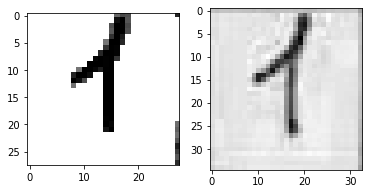

1 0.9999988


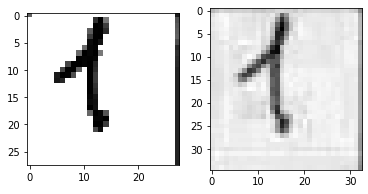

7 0.92072725


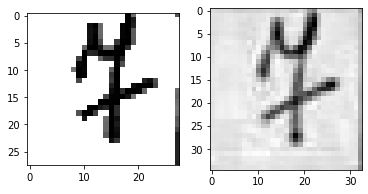

9 0.9913641


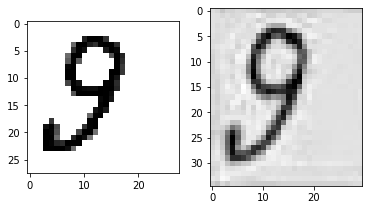

3 0.9999995


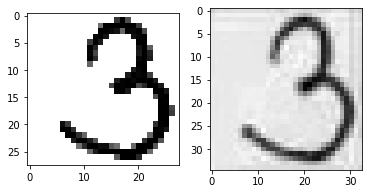

1 0.9999981


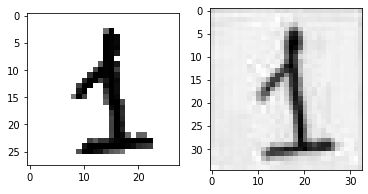

1 0.99601644


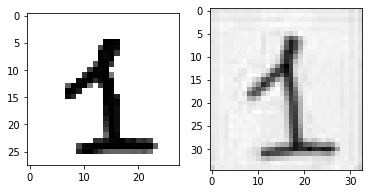

2 0.9999906


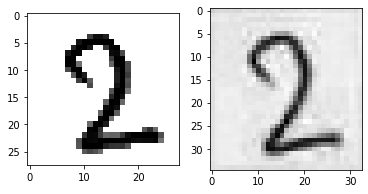

7 0.9385515


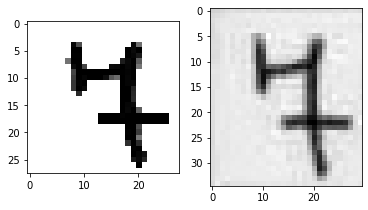

1 0.9970763


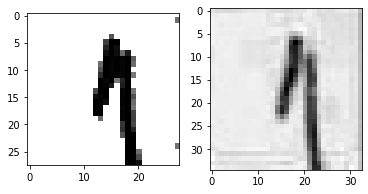

1 1.0


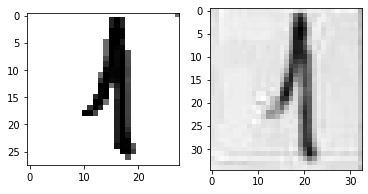

1 0.9999999


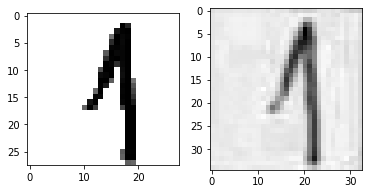

9 0.9766148


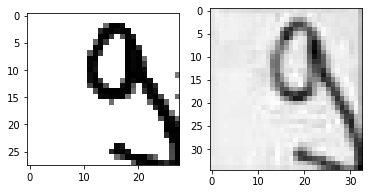

5 0.99954385


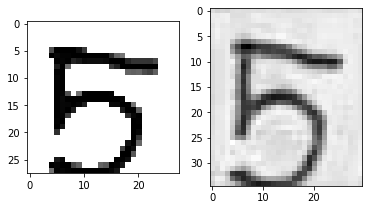

3 0.9999999


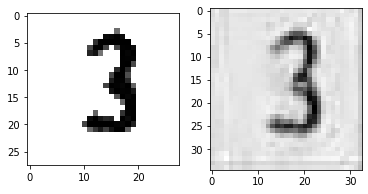

3 1.0


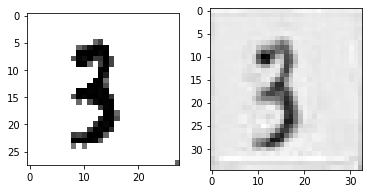

0 1.0


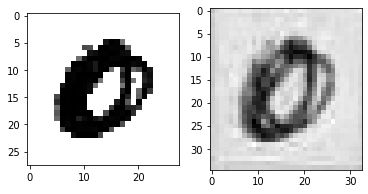

2 1.0


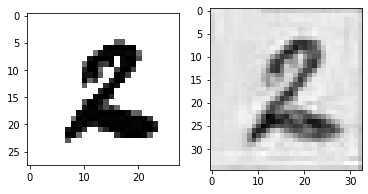

2 1.0


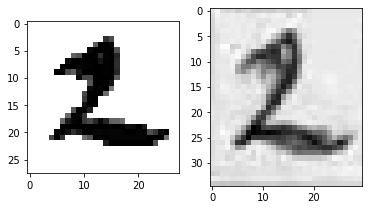

1 0.9999999


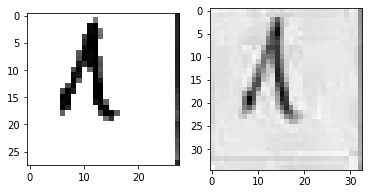

3 0.9999989


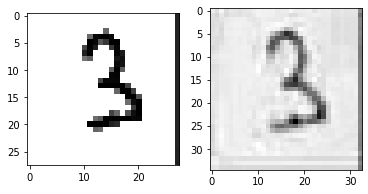

1 1.0


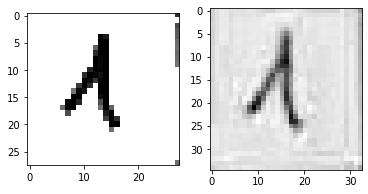

1 1.0


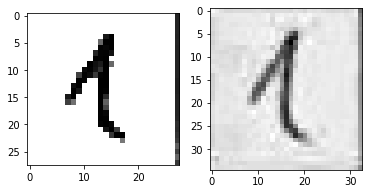

3 0.9999993


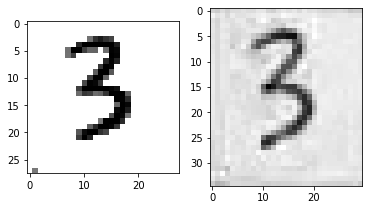

3 0.99410313


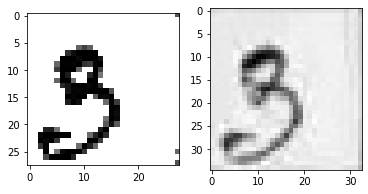

1 0.99988556


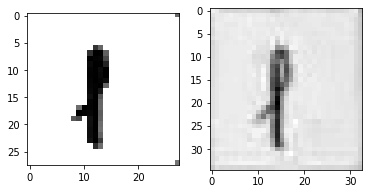

1 0.99992764


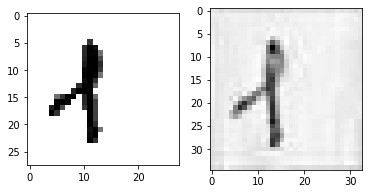

3 1.0


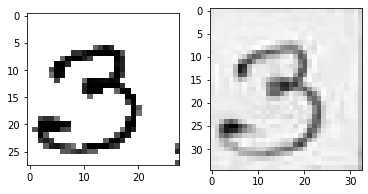

0 0.999977


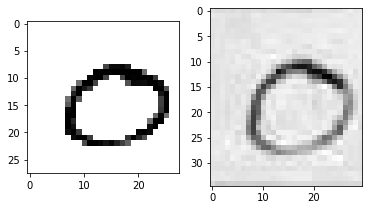

3 1.0


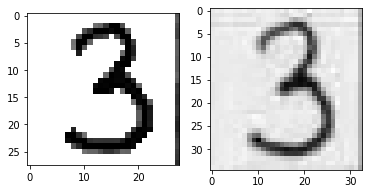

3 1.0


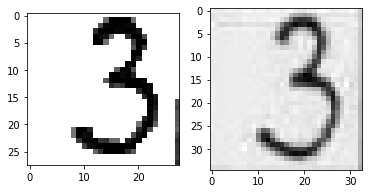

0 1.0


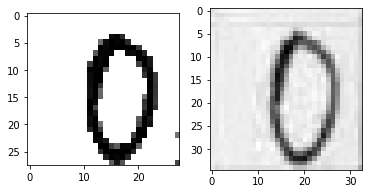

0 0.9999999


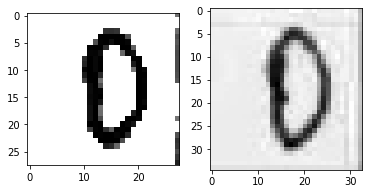

1 1.0


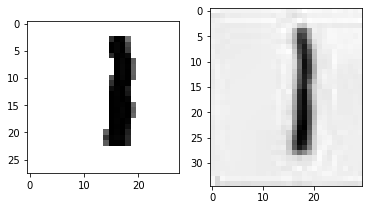

3 0.99946886


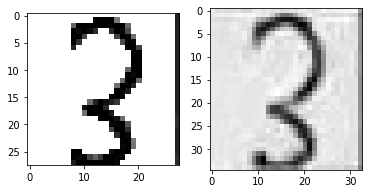

3 0.9999697


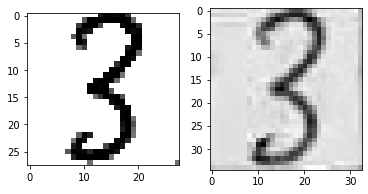

0 0.9999999


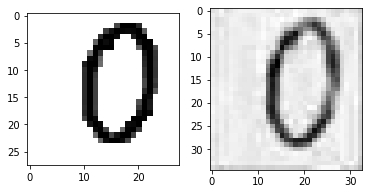

0 0.99999523


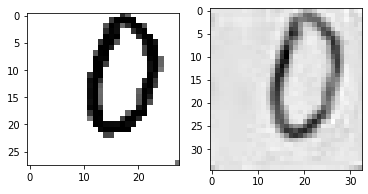

4 0.99990535


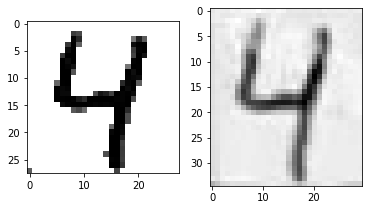

1 0.99997854


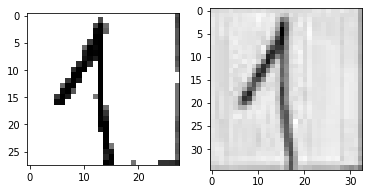

3 0.99993014


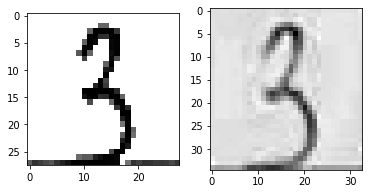

1 1.0


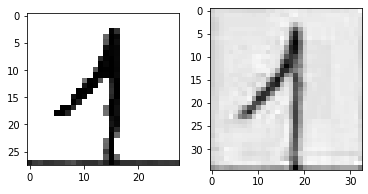

1 0.99999905


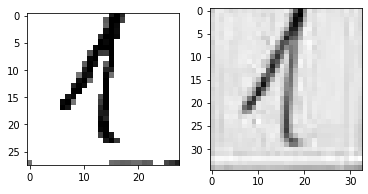

6 0.98265404


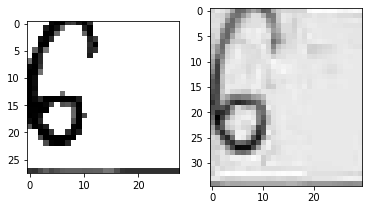

3 0.99999833


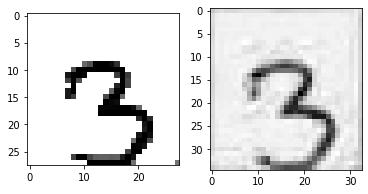

3 1.0


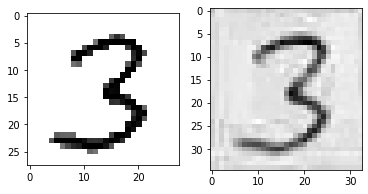

1 1.0


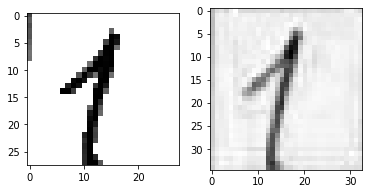

9 0.99999905


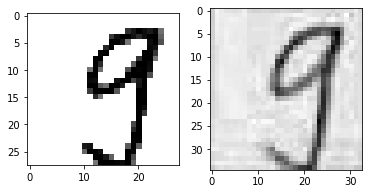

5 0.7348843


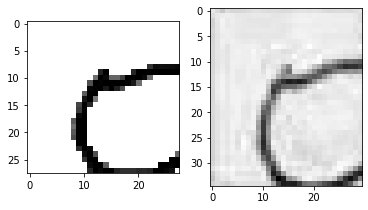

3 0.99967694


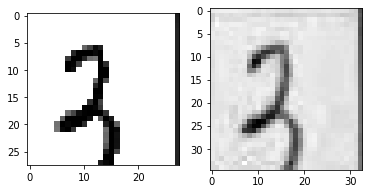

1 0.99999344


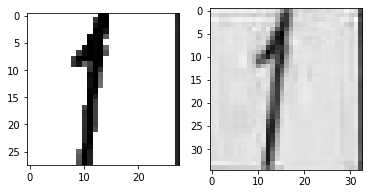

0 1.0


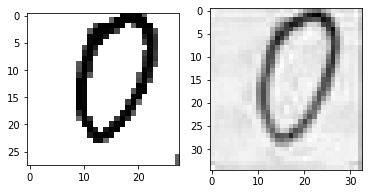

8 0.99998343


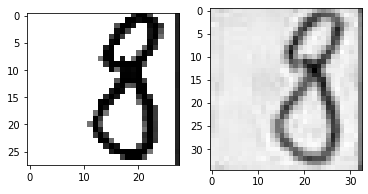

1 0.9999938


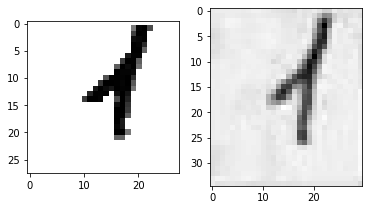

3 1.0


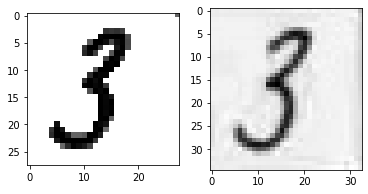

3 1.0


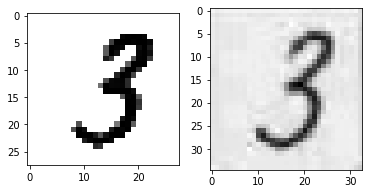

1 0.9992161


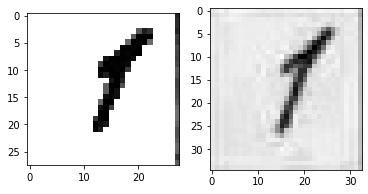

0 0.99998224


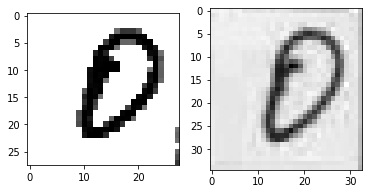

2 1.0


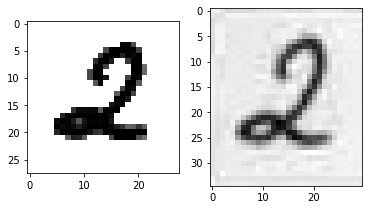

3 1.0


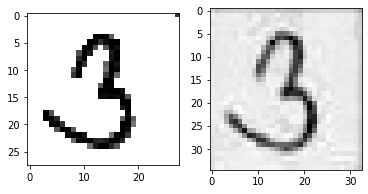

3 0.99740124


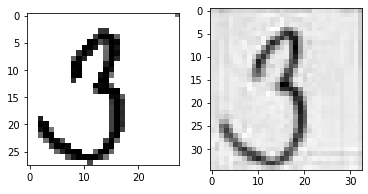

0 1.0


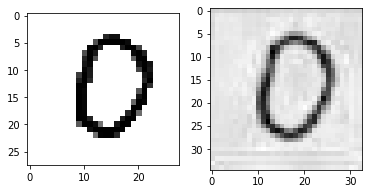

5 0.9998841


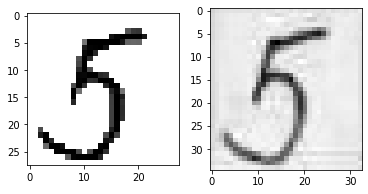

8 0.9999993


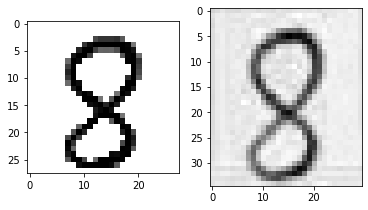

3 1.0


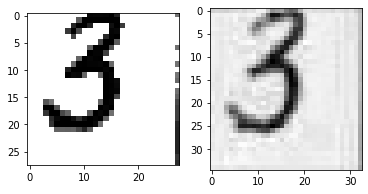

3 0.9999999


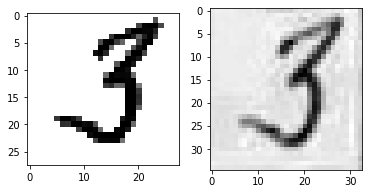

0 0.9999958


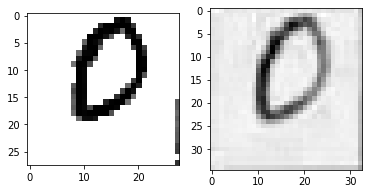

7 0.9999919


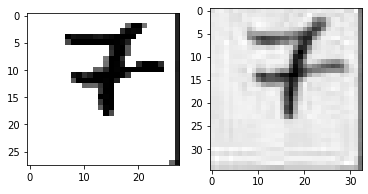

5 1.0


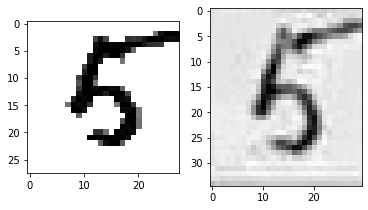

1 1.0


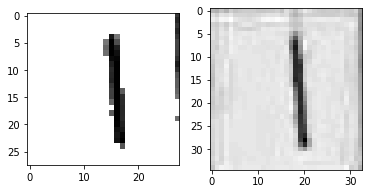

3 1.0


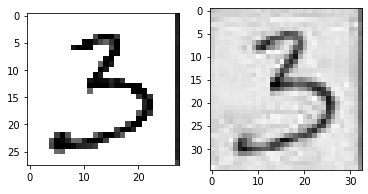

1 0.9999999


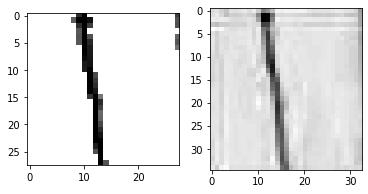

0 0.99697506


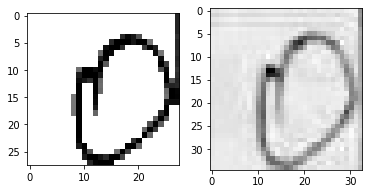

3 0.91549724


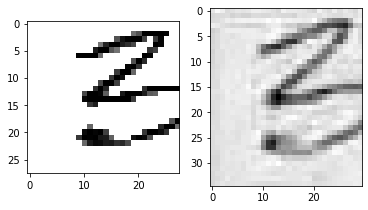

1 0.99999523


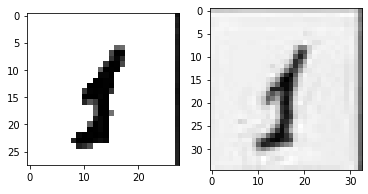

1 0.99398094


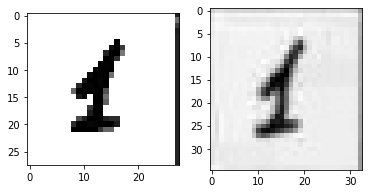

1 0.9995326


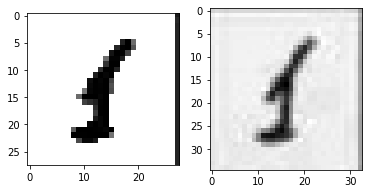

7 1.0


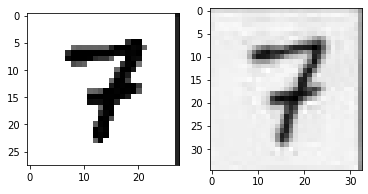

0 0.99996674


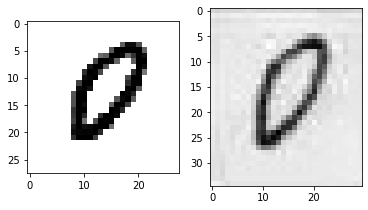

3 0.9999999


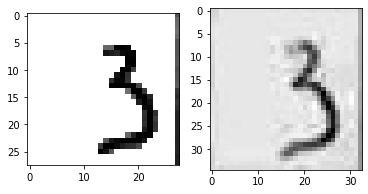

7 0.98715323


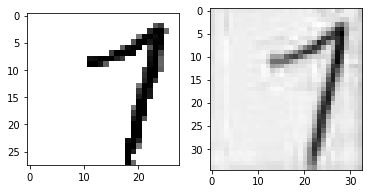

0 0.9999995


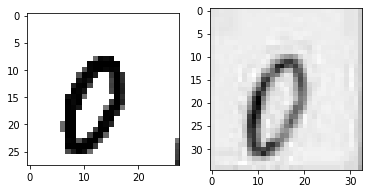

4 0.99867225


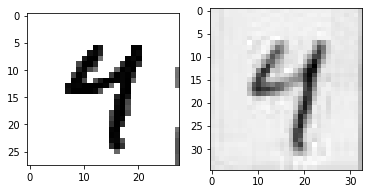

8 1.0


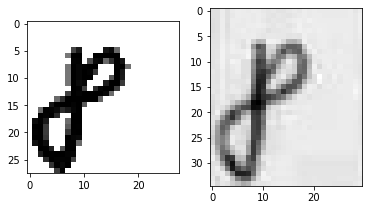

3 0.99999976


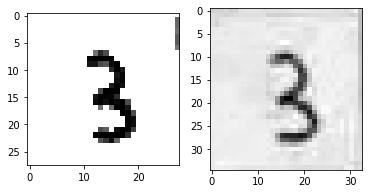

3 0.99997437


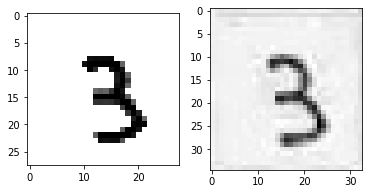

0 0.97236335


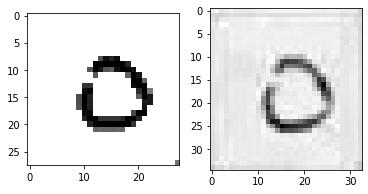

5 1.0


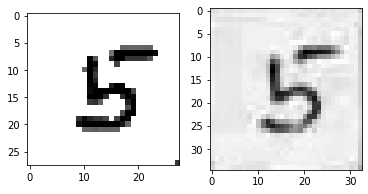

7 0.99999964


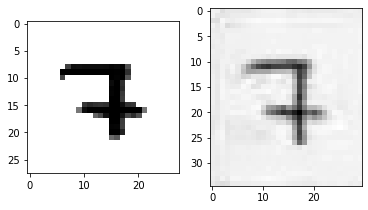

3 0.99999833


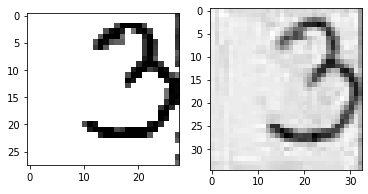

1 1.0


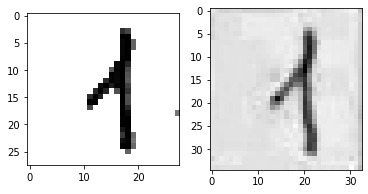

0 1.0


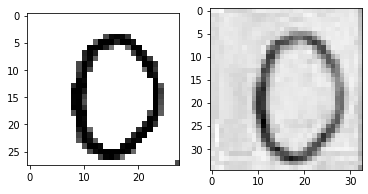

4 0.99999976


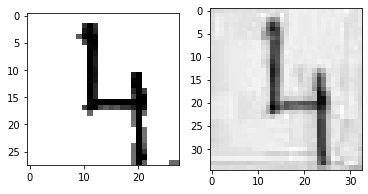

9 0.9998062


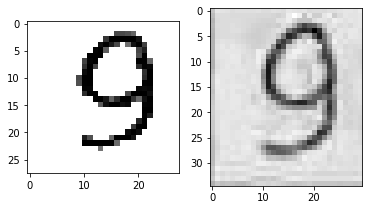

3 0.9999745


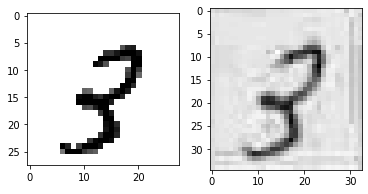

1 0.9999957


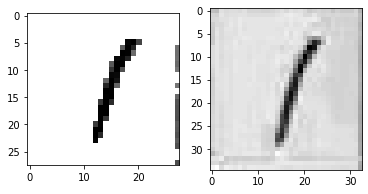

0 0.9994797


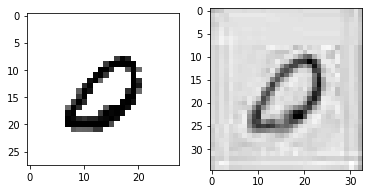

6 0.99253064


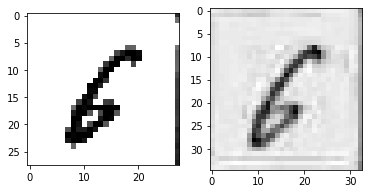

3 0.9999999


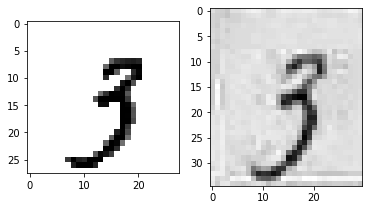

3 0.9999714


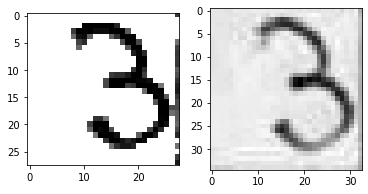

3 0.9999548


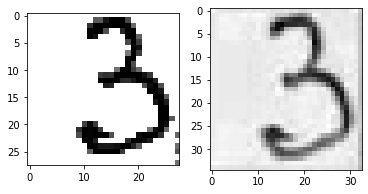

0 0.9999999


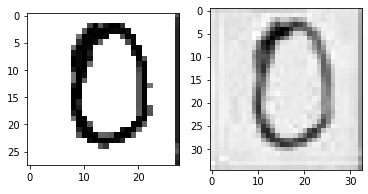

6 0.999577


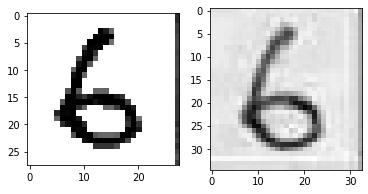

4 0.99999917


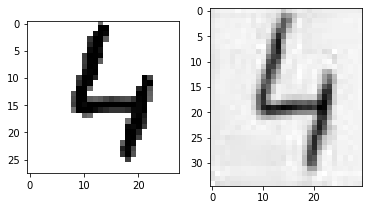

3 1.0


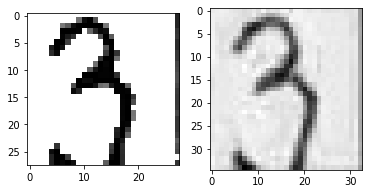

3 1.0


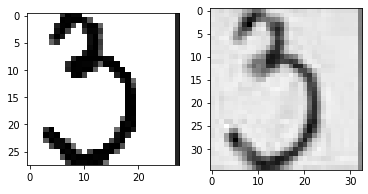

1 1.0


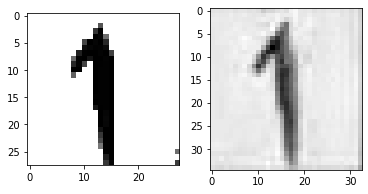

2 1.0


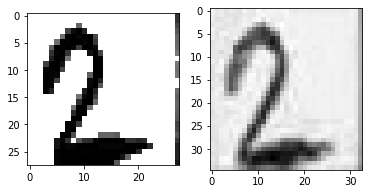

5 1.0


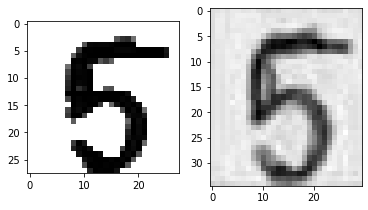

3 1.0


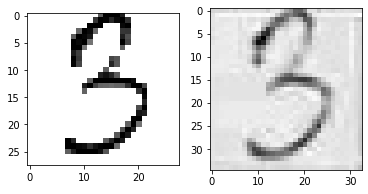

1 0.9988477


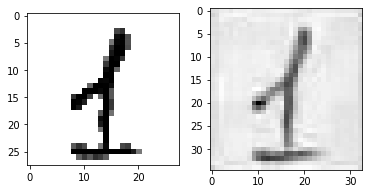

1 0.9999999


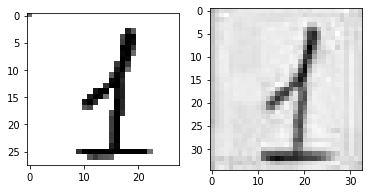

4 0.99945873


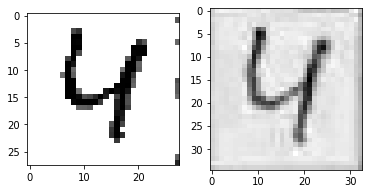

5 1.0


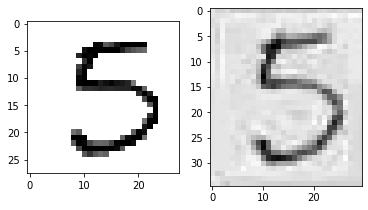

1 0.9999976


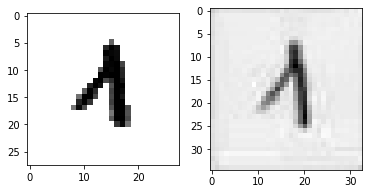

3 1.0


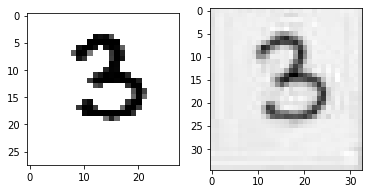

1 0.9996667


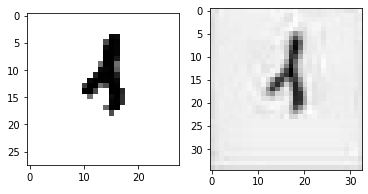

1 0.9998499


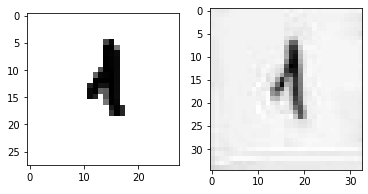

2 0.9999999


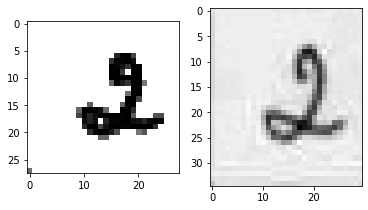

3 1.0


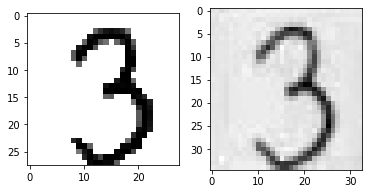

3 1.0


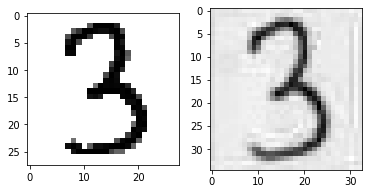

1 1.0


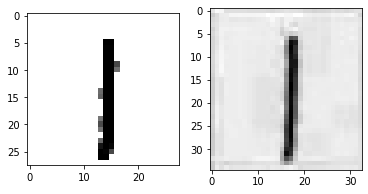

8 0.999998


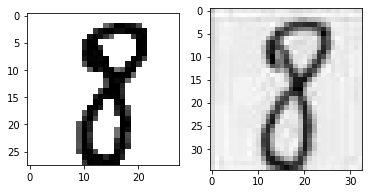

9 0.9999939


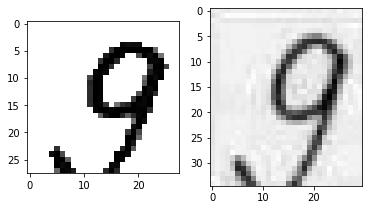

1 0.9999465


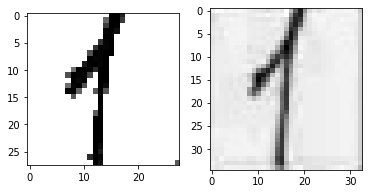

3 0.99999774


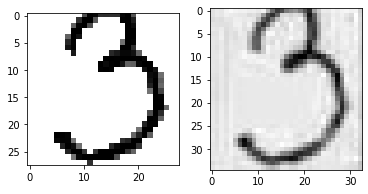

1 0.99999964


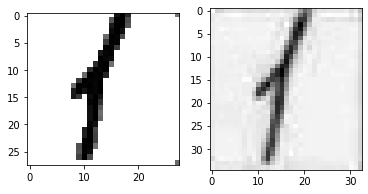

1 0.9980648


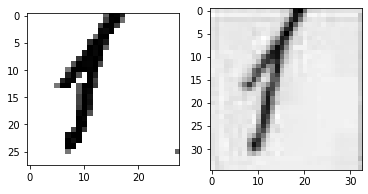

7 0.99248236


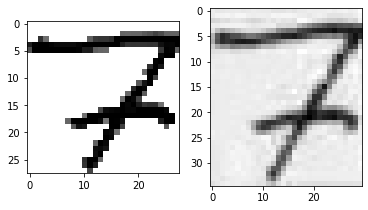

3 0.9999981


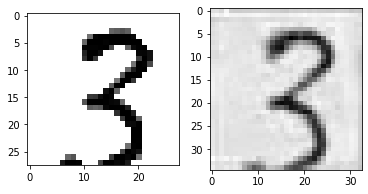

3 1.0


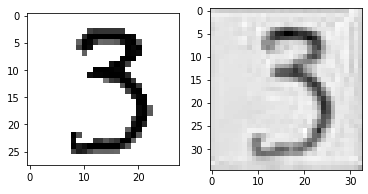

0 1.0


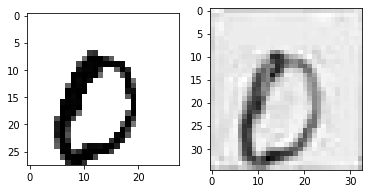

1 0.99999726


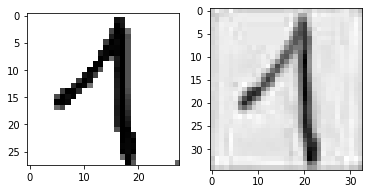

6 0.9999999


KeyboardInterrupt: 

In [254]:
train_digits = all_digits[: 800]

__________________________________________
8 0.9997671


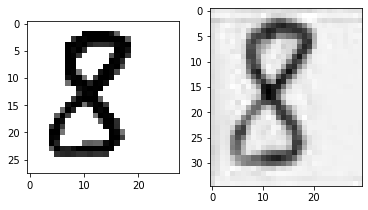


__________________________________________
2 0.42443052


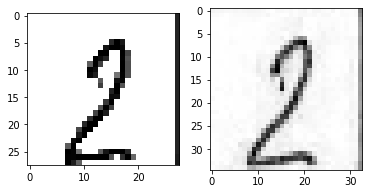

2
__________________________________________
7 0.9556728


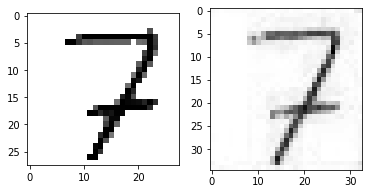


__________________________________________
1 0.22003467


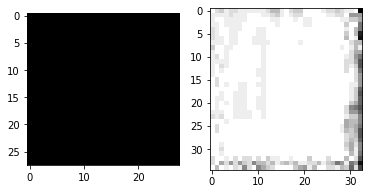


__________________________________________
1 0.22003467


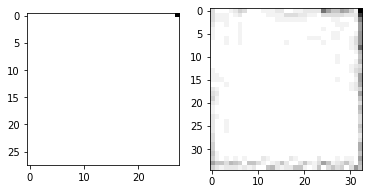


__________________________________________
1 0.22003467


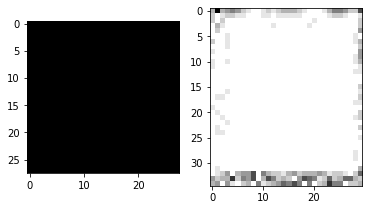


__________________________________________
1 0.9166345


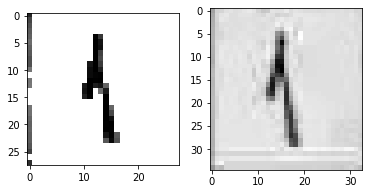


__________________________________________
1 0.72774225


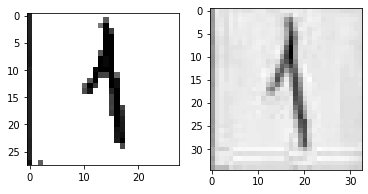

1
__________________________________________
1 0.79946464


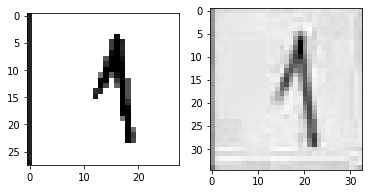

1
__________________________________________
7 0.99158365


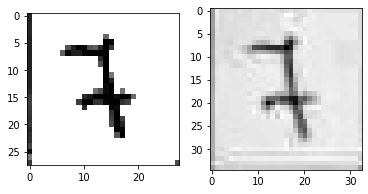


__________________________________________
7 0.97270995


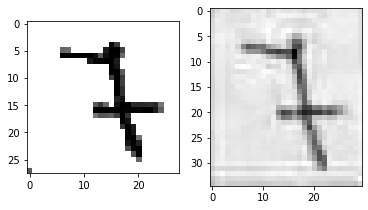


__________________________________________
1 0.8958997


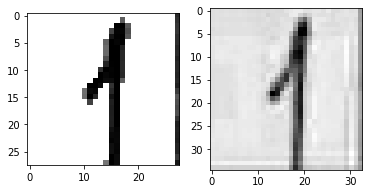


__________________________________________
3 0.9999937


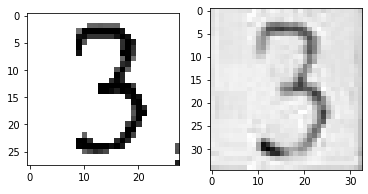


__________________________________________
4 0.5689515


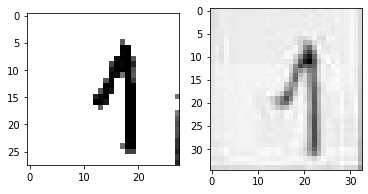


__________________________________________
0 0.99982077


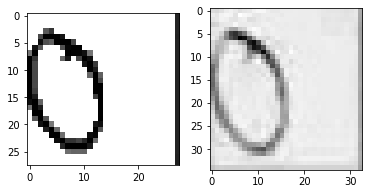


__________________________________________
1 0.973431


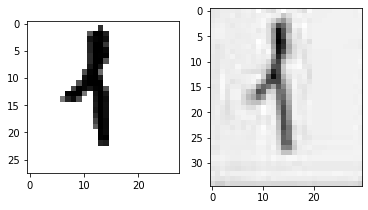


__________________________________________
3 0.80689496


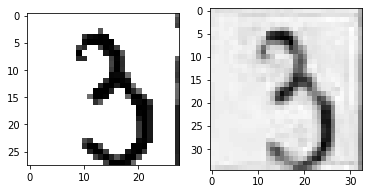

3
__________________________________________
3 0.99998796


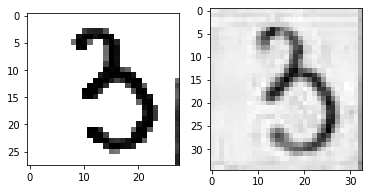


__________________________________________
0 1.0


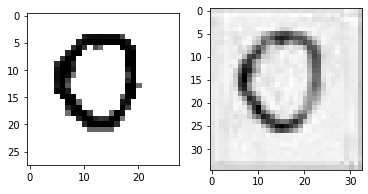


__________________________________________
5 0.99999845


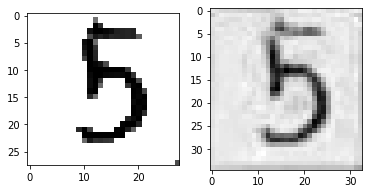

5
__________________________________________
7 0.75241745


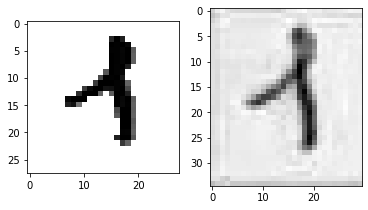

1
__________________________________________
3 1.0


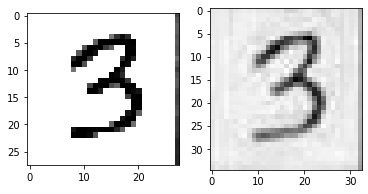

3
__________________________________________
3 0.9999877


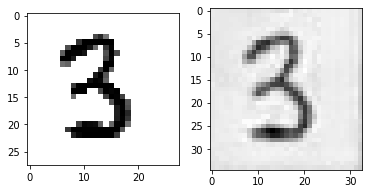


__________________________________________
0 0.9999999


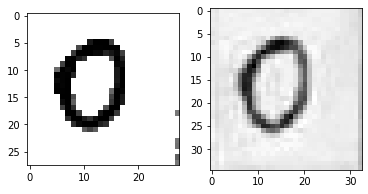


__________________________________________
8 0.99997973


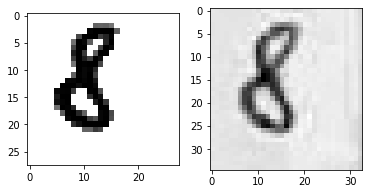


__________________________________________
2 0.999995


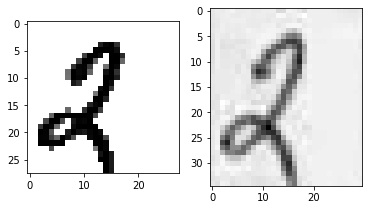

2
__________________________________________
3 0.9999286


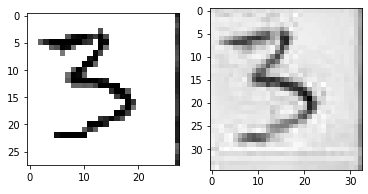

3
__________________________________________
3 0.9999981


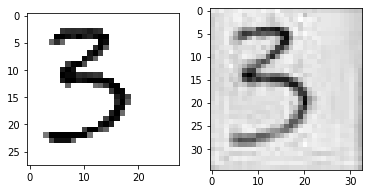

3
__________________________________________
0 1.0


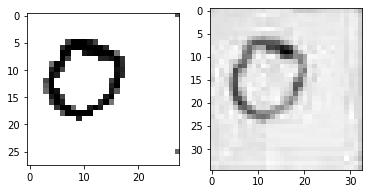

0
__________________________________________
5 0.9292503


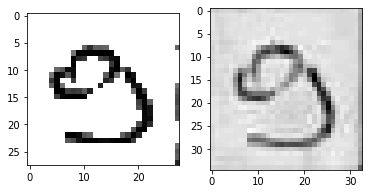

9
__________________________________________
6 0.99999833


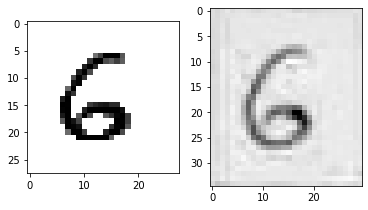


__________________________________________
3 0.9999784


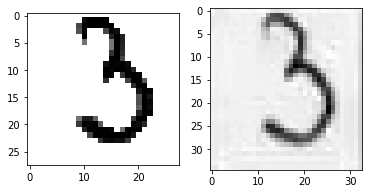


__________________________________________
1 0.99971896


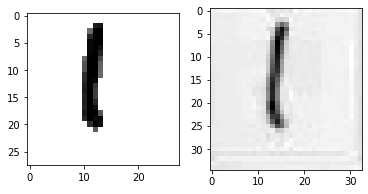

1
__________________________________________
6 0.8901085


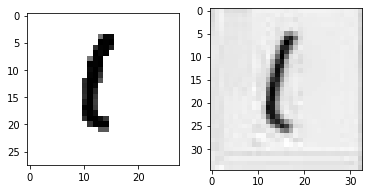

1
__________________________________________
0 0.9999993


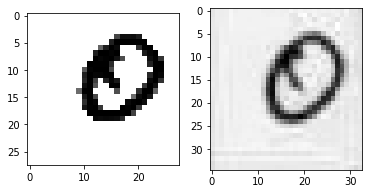


__________________________________________
3 1.0


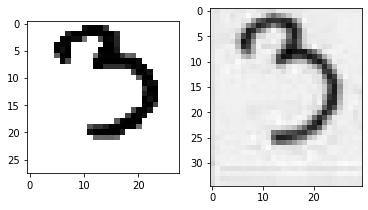


__________________________________________
3 0.94225997


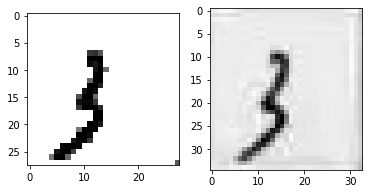


__________________________________________
7 0.98381966


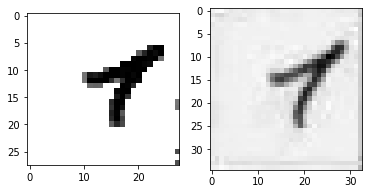

1
__________________________________________
0 0.9986625


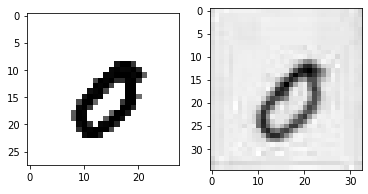


__________________________________________
5 0.9999995


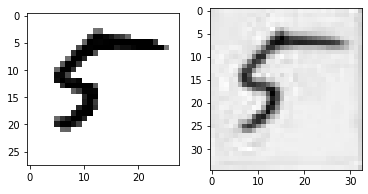

5
__________________________________________
2 1.0


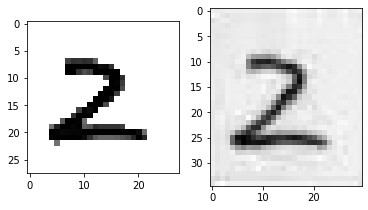

2
__________________________________________
3 0.58428264


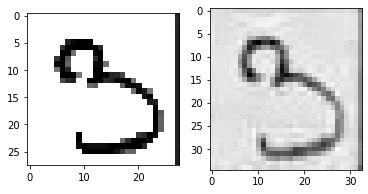

3
__________________________________________
3 0.999995


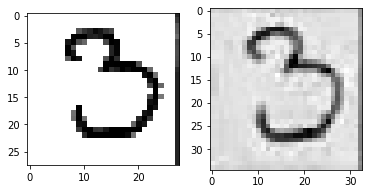


__________________________________________
0 0.9995479


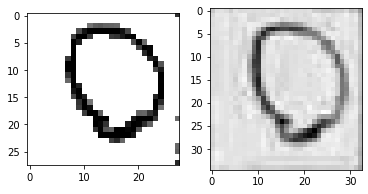

0
__________________________________________
0 1.0


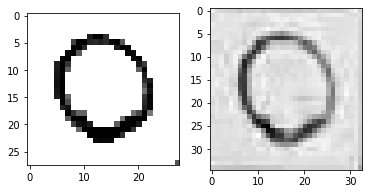


__________________________________________
7 0.6977583


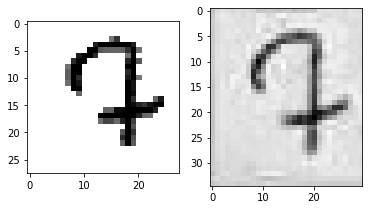

7
__________________________________________
4 0.7927672


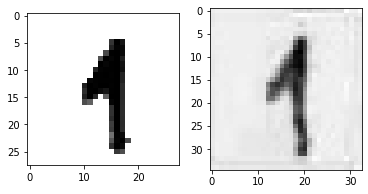

1
__________________________________________
3 1.0


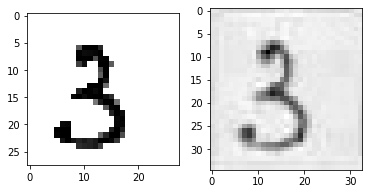

3
__________________________________________
1 0.6954449


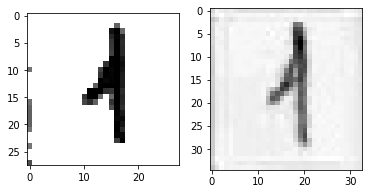

1
__________________________________________
1 0.6009549


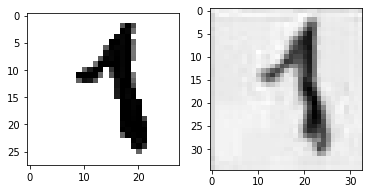

1
__________________________________________
8 0.9999701


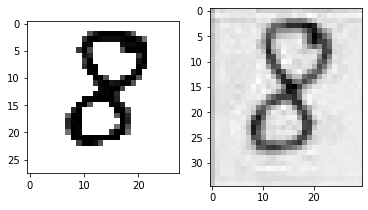


__________________________________________
3 0.99693584


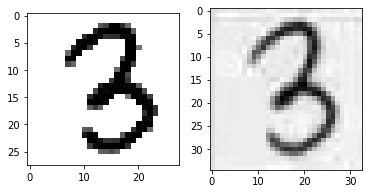


__________________________________________
1 0.98827285


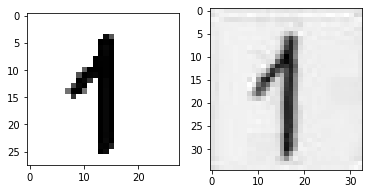


__________________________________________
0 1.0


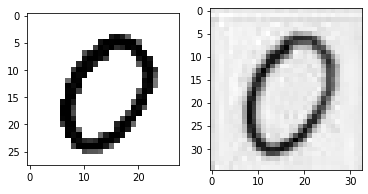


__________________________________________
5 0.99990726


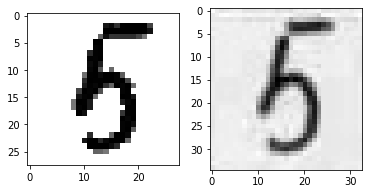


__________________________________________
5 0.99999976


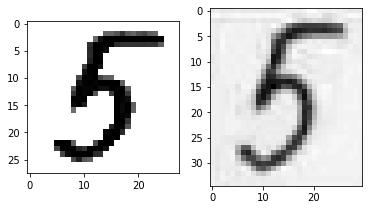

5
__________________________________________
1 0.9999994


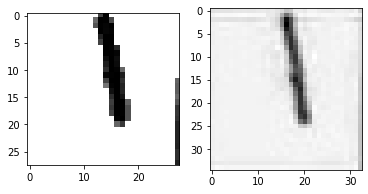

1
__________________________________________
3 1.0


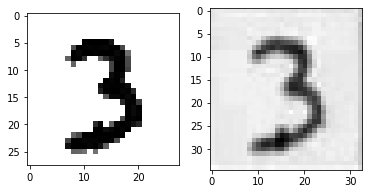


__________________________________________
1 1.0


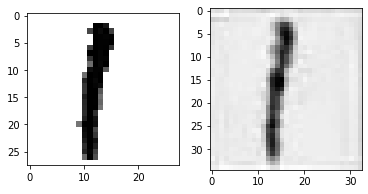


__________________________________________
1 1.0


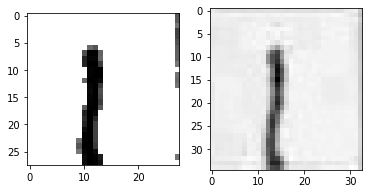


__________________________________________
1 1.0


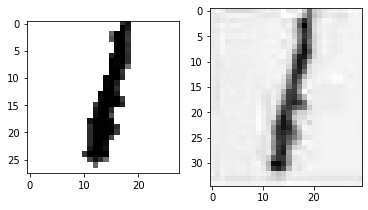


__________________________________________
2 0.82487875


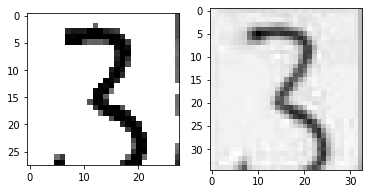

3
__________________________________________
1 1.0


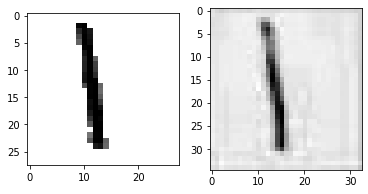


__________________________________________
0 1.0


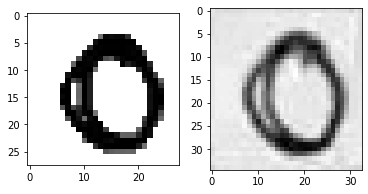


__________________________________________
0 0.69715333


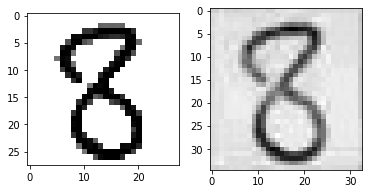

8
__________________________________________
0 0.99999833


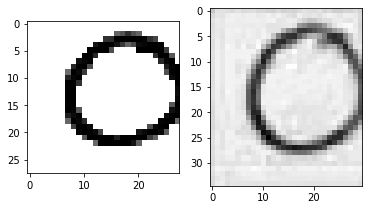

0
__________________________________________
1 0.99999785


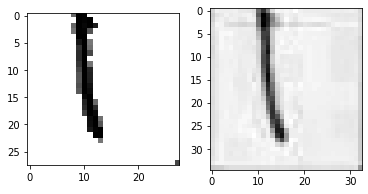

1
__________________________________________
1 1.0


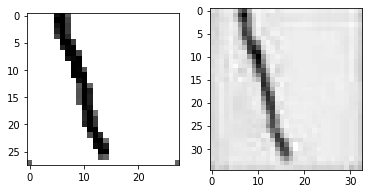

1
__________________________________________
1 1.0


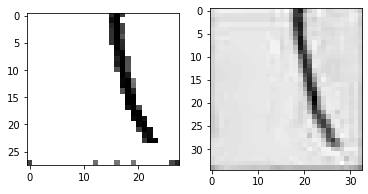


__________________________________________
0 0.88977724


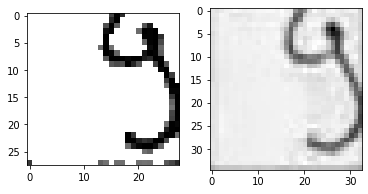

9
__________________________________________
1 0.9999999


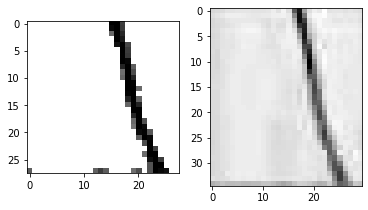


__________________________________________
3 0.99987996


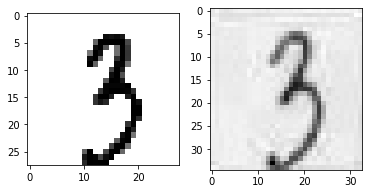


__________________________________________
3 0.9999496


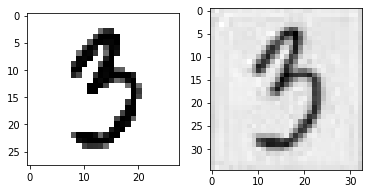


__________________________________________
0 1.0


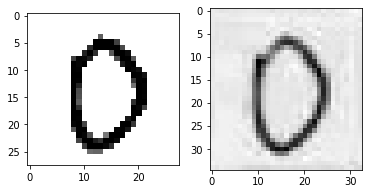


__________________________________________
4 0.9999987


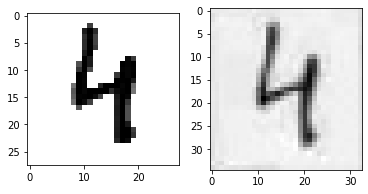

4
__________________________________________
9 0.729162


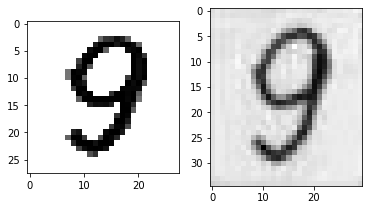

9
__________________________________________
3 0.99998283


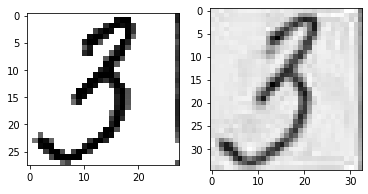


__________________________________________
3 0.99999964


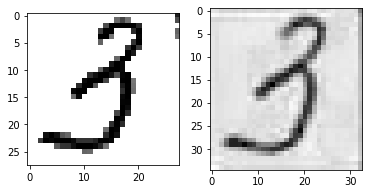


__________________________________________
0 1.0


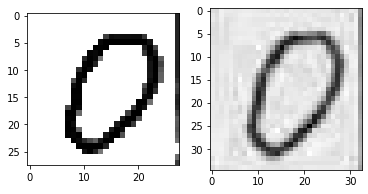

0
__________________________________________
0 0.99572754


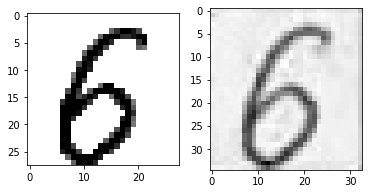


__________________________________________
7 0.9864239


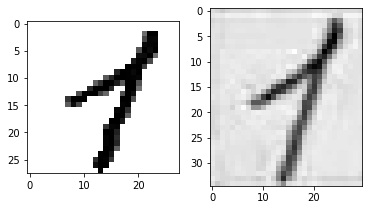

1
__________________________________________
3 0.9895985


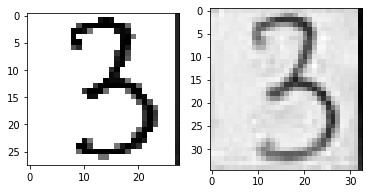


__________________________________________
3 0.99807715


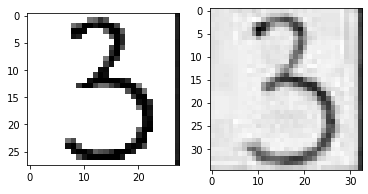

3
__________________________________________
1 0.75583345


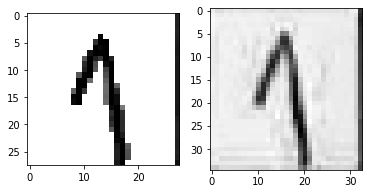

1
__________________________________________
0 1.0


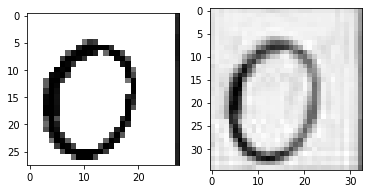


__________________________________________
7 0.71043456


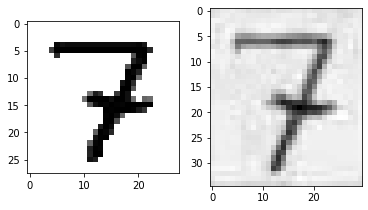

7
__________________________________________
3 0.9999999


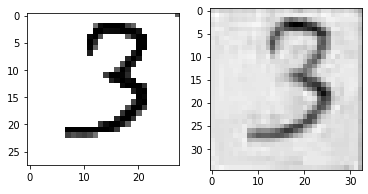


__________________________________________
7 0.9975896


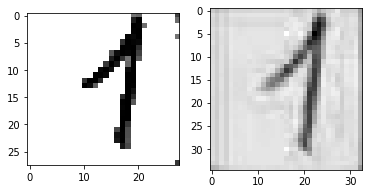

1
__________________________________________
0 1.0


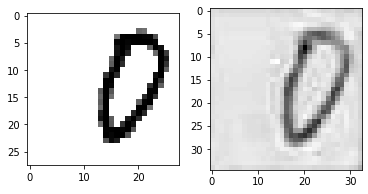

0
__________________________________________
8 0.99650997


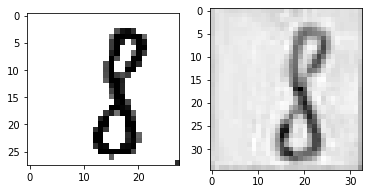

8
__________________________________________
5 1.0


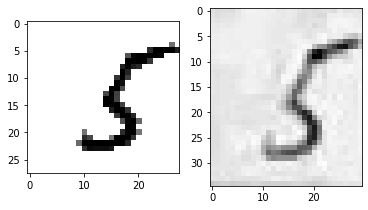

5
__________________________________________
3 0.9999999


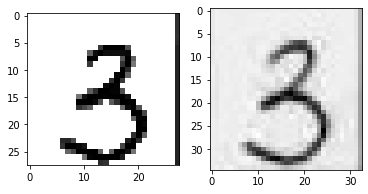


__________________________________________
1 0.9999994


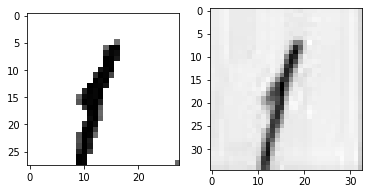


__________________________________________
0 1.0


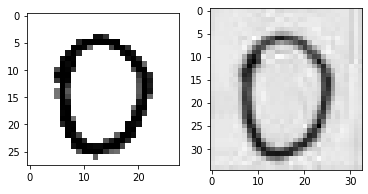

0
__________________________________________
9 0.9967926


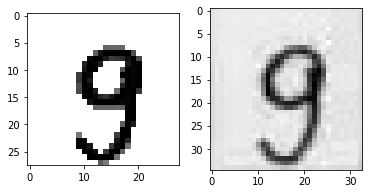

9
__________________________________________
2 0.9999629


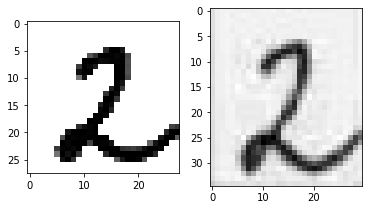

2
__________________________________________
3 0.99999857


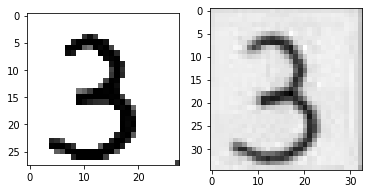


__________________________________________
3 0.99999857


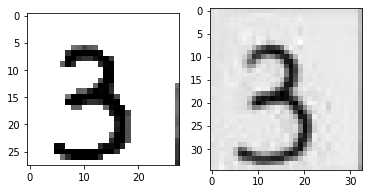


__________________________________________
0 0.9999999


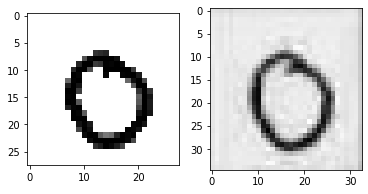


__________________________________________
7 0.9999995


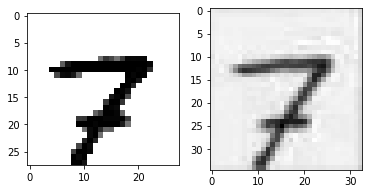


__________________________________________
9 0.9959329


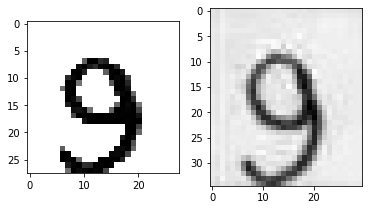


__________________________________________
3 1.0


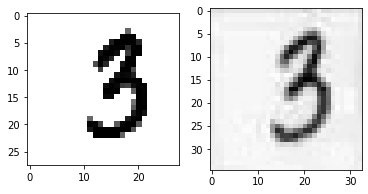


__________________________________________
3 1.0


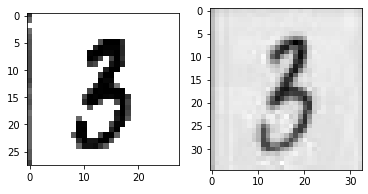


__________________________________________
1 0.8361732


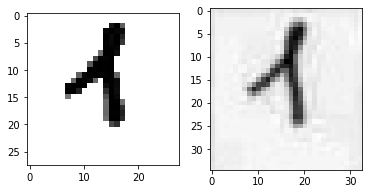

1
__________________________________________
1 0.999597


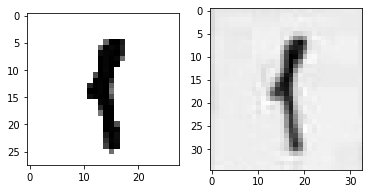


__________________________________________
9 0.9993591


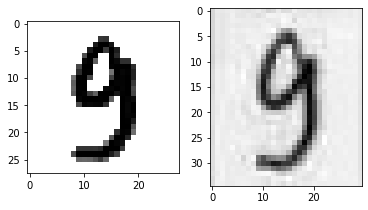


__________________________________________
3 0.9999999


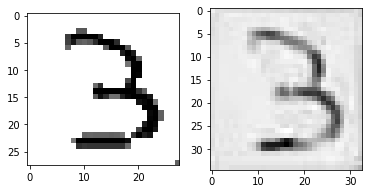

3
__________________________________________
1 1.0


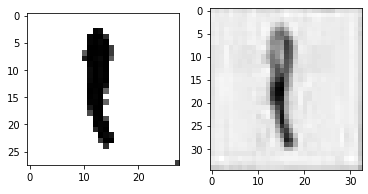

1
__________________________________________
0 1.0


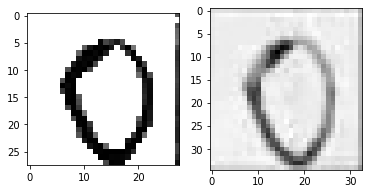

0
__________________________________________
6 1.0


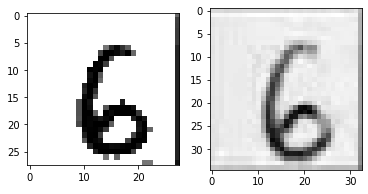

6
__________________________________________
2 0.93069994


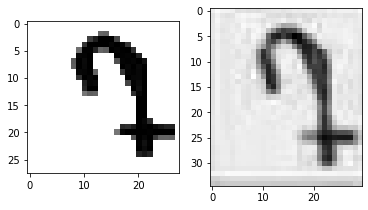

7
__________________________________________
3 0.99999857


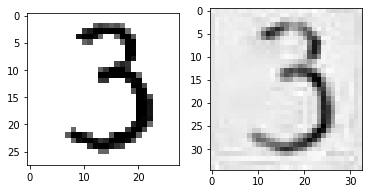


__________________________________________
1 0.71915495


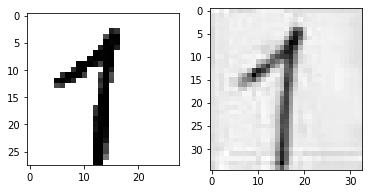

1
__________________________________________
1 0.7811728


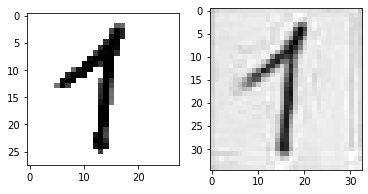

1
__________________________________________
0 1.0


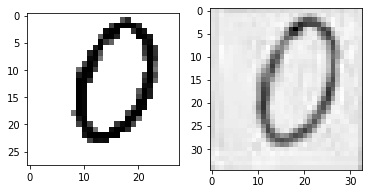

0
__________________________________________
6 0.9986111


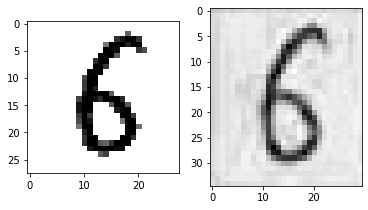


__________________________________________
1 0.22003467


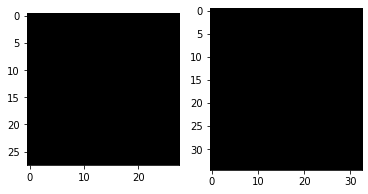


__________________________________________
1 0.22003467


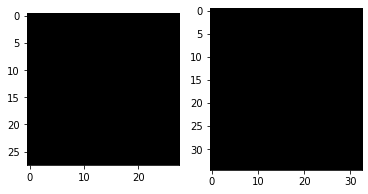


__________________________________________
1 0.22003467


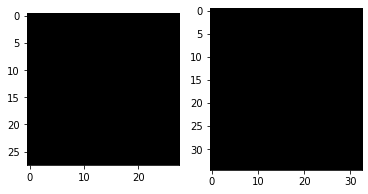


__________________________________________
1 0.22003467


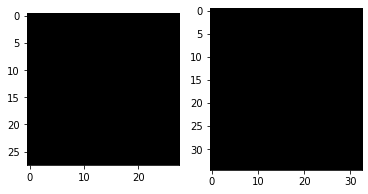


__________________________________________
1 0.22003467


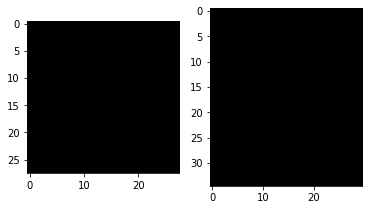


__________________________________________
3 0.99975735


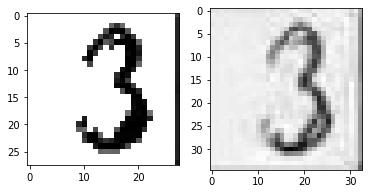


__________________________________________
3 0.9784833


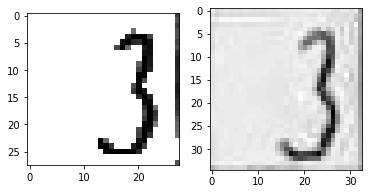


__________________________________________
1 0.8333886


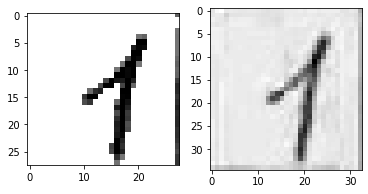

1
__________________________________________
2 0.99999976


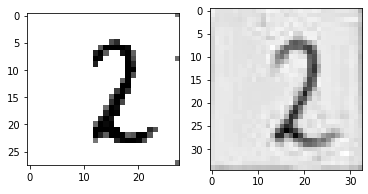

2
__________________________________________
2 0.9866534


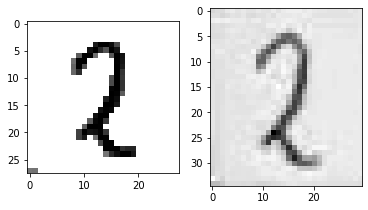

2
__________________________________________
3 0.85538644


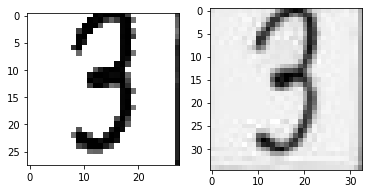

3
__________________________________________
3 0.9865079


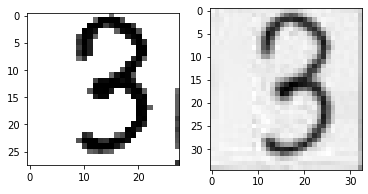


__________________________________________
2 0.6195035


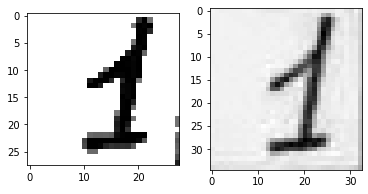

1
__________________________________________
2 1.0


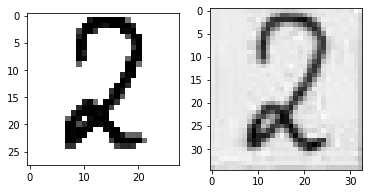

2
__________________________________________
0 0.9999945


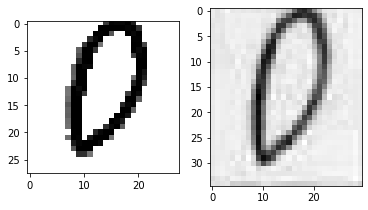


__________________________________________
3 0.9998976


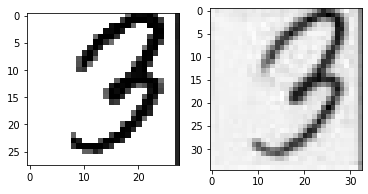


__________________________________________
3 0.9973617


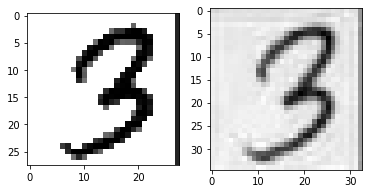


__________________________________________
0 1.0


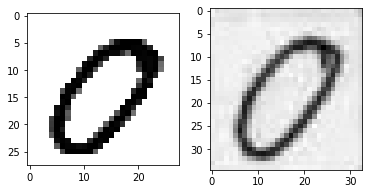


__________________________________________
9 0.92293906


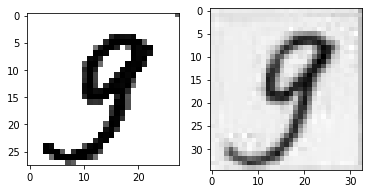

9
__________________________________________
8 0.99999833


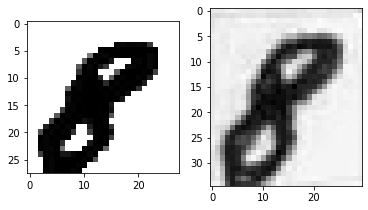

8
__________________________________________
3 0.9586053


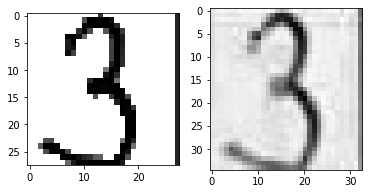

3
__________________________________________
1 0.9989768


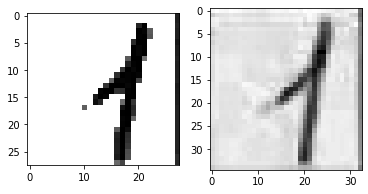

KeyboardInterrupt: 

In [272]:
for digit in train_digits[514:]:
    print("__________________________________________")
    recognize_and_print_digit(digit)
    what_to_do = input().strip()
    
    if not what_to_do.strip() == "":
        filename = "our_sample_data/{}_{}.png".format(what_to_do, rand_line())
        im = Image.fromarray(digit.astype(np.uint8))
        im.save(filename)

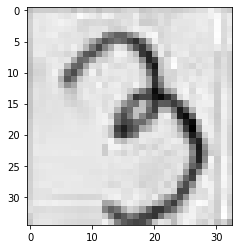

In [232]:
plt.imshow(all_digits[0], "gray")